(dans dW)
Pq? pcq Wti+1 - Wti ~ N(0, dt) et que c'est ce qu'on realise n fois avec la comande dW (0 à N_1)

In [48]:
# MC Simulation of Future price paths

# np.linspace(0, 1, 5) : array([0., 0.25, 0.5, 0.75, 1.0])

def prices(mu, sigma, T, N):
    # N number of subdivisions of [0, T]
    delta = T/N
    time = [k*delta for k in range(N+1)]
    B = np.random.normal(0, time)
    return np.exp((mu - 0.5*sigma**2)*time + sigma*B)

# N number of points for the simulation
# np.cumsum([a, b, c]) = [a, a+b, a+b+c]

def prices(S0, mu, sigma, T, N):
    dt = T/N
    times = np.linspace(0, T, N+1) # [0, 1*T/N, ...., N*(T/N)] 
    dW = np.random.normal(0, np.sqrt(dt), N) # Brownian Motion increments : [Wt1 - Wt0, Wt2-Wt1, ..., Wtn-Wt(n-1)]
    W = np.insert(np.cumsum(dW), 0, 0) # np.cumsum(dW) = [Wt1, Wt2, ...Wtn] and insert for W0=0
    S = S0 * np.exp((mu-0.5*sigma**2)*times + sigma*W)
    return times, S

In [49]:
def volatility(prices):
    # volatilite sur 10 jours
    n = len(prices)
    volatilities = []
    for i in range(n-10+1):
        considered = prices[i:i+10]
        returns = [(considered[j+1] - considered[j]) / considered[j] for j in range(9)]
        expected_return = (1/10)*np.sum(returns)
        volatility = (1/10)*np.sum([(retour - expected_return)**2 for retour in returns])
        volatilities.append(volatility)
    return volatilities

In [50]:
# prices : list of prices 

def percentage(prices, x):
    moments = []
    n = len(prices)
    for i in range(n-1):
        evolution = (prices[i+1] - prices[i]) / prices[i]
        if np.abs(evolution) > x:
            moments.append(i+1)
    return moments

In [51]:
def potential_peaks(prices):
    peaks = []
    n = len(prices)
    if prices[0] > prices[1]:
        peaks.append(0)
    for i in range(1,n-1):
        if prices [i] > max(prices[i-1], prices[i+1]):
            peaks.append(i)
    if prices[-1] > prices[n-2]:
        peaks.append(n-1)
    return peaks


def cumulative_returns(prices):
    n = len(prices)
    cumulative = [(prices[i]-prices[0]) / prices[0] for i in range(n)]
    return cumulative


# Return the (buy_day, sell_day) that gives the max profit. Only one trade allowed.
def max_profit(prices):
    n = len(prices)
    min_price = prices[0]
    max_profit = 0
    min_day = 0
    buy_day = 0
    sell_day = 0
    for i in range(1,n):
        if prices[i] - min_price > max_profit:
            max_profit = prices[i] - min_price
            sell_day = i
            buy_day = min_day
        if prices[i] < min_price: # keep the min value and its index
            min_price = prices[i]
            min_day = i
    return [buy_day, sell_day]
    

# sharpe ratio : E[R] - Rf / sigma(R), where Rf is the risk free rate
# Here, we suppose Rf = 0
def sharpe_ratio(prices):
    n = len(prices)
    returns = [(prices[i+1] - prices[i]) / prices[i] for i in range(n-1)]
    variance = np.mean([(r - np.mean(returns))**2 for r in returns])
    std = np.sqrt(variance)
    return np.mean(returns) / std
    

# Create a list of +1 if price goes up, -1 if it goes down, 0 if flat.   
def binary_signal(prices):
    n = len(prices)
    binary = [0]*(n-1)
    for i in range(n-1):
        if prices[i+1] > prices[i]:
            binary[i] = 1
        elif prices[i] > prices[i+1]:
            binary[i] = -1
        else:
            binary[i] = 0
    return binary

# MA of window size k : 1/k sum of j from i to i+k-1 of pj when i + k <= n with n = len(prices)
# To be continued ... def moving_averages(prices, k):
   # n = len(prices)
   # average = [0]*(n-k+1)
   # for i in range(n-k+1):
   # average[i] = np.mean(prices[i:i+k]) 
   # for i in range(1, n-k+1):

# Correction below
def golden_cross(prices, short_window, long_window):
    short_ma = moving_averages(prices, short_window)
    long_ma = moving_averages(prices, long_window)

    # Align lengths: cut the beginning of the longer one
    offset = long_window - short_window
    if offset > 0:
        short_ma = short_ma[offset:]
    elif offset < 0:
        long_ma = long_ma[-offset:]

    # Now both MAs have length = len(prices) - max(short_window, long_window) + 1
    n = len(short_ma)
    crosses = []

    for i in range(1, n):
        if short_ma[i - 1] < long_ma[i - 1] and short_ma[i] >= long_ma[i]:
            # The actual index in the original price list (adjusted)
            actual_index = i + max(short_window, long_window) - 1
            crosses.append(actual_index)

    return crosses

In [52]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def first_duplicate(liste):
    occurence = defaultdict(int)
    for x in liste:
        occurence[x] += 1
        if occurence[x] > 1:
            return x
    return None


def sample_variance(liste):
    returns = []
    n = len(liste)
    returns = [(liste[i]/liste[i-1]) - 1 for i in range(1,n)]
    mean = sum(returns) / (n-1) # bc returns has n-1 elements
    somme = sum([(r - mean)**2 for r in returns])
    return somme / (n-1)

def moving_average(liste, k):
    n = len(liste)
    moving_averages = []
    for i in range(n-k+1):
        moving_average = sum(liste[i:i+k]) / k
        moving_averages.append(moving_average)
    return moving_averages


def cumulative_returns(liste):
    n = len(liste)
    cum_returns = [(liste[i] / liste[0]) - 1 for i in range(1,n)]
    return cum_returns

def sharpe_ratio(liste): # We suppose the risk-free rate is 0, sr = (expected_return_portfolio - risk_free) / std_returns
    returns = [(liste[i] / liste[i-1]) - 1 for i in range(1,n)]
    expected_returns = np.mean(returns)
    std_returns = np.std(returns)
    return expected_returns / std_returns

def price_mov(liste, x):
    movements = []
    for i in range(1,len(liste)):
        if np.abs((liste[i] / liste[i-1]) - 1) * 100 > x:
            movements.append(i)
    return movements

def brownian_motion(T, N):  # B0 = 0 and Bt+Δt−Bt∼N(0,Δt) and dt = T/N
    # T is the horizon (we study B on [0, T])
    # We work with N subdivisions of this interval
    times = np.linspace(0, T, N+1)
    dt = T/N
    dB = np.random.normal(0, np.sqrt(dt), N) # B1, B2-B1, ...., Bn-B(n-1) ~ N(0,1)
    B = np.insert(np.cumsum(dB), 0, 0) # B = (B0, B1, B2, ...., BN)
    plt.plot(times, B, label=f"Path of the BMs on [0, {T}]")
    plt.xlabel("Steps")
    plt.ylabel("BM")
    plt.title("Simulation of the Path of a BM")
    plt.grid(True)
    plt.legend()
    plt.show()

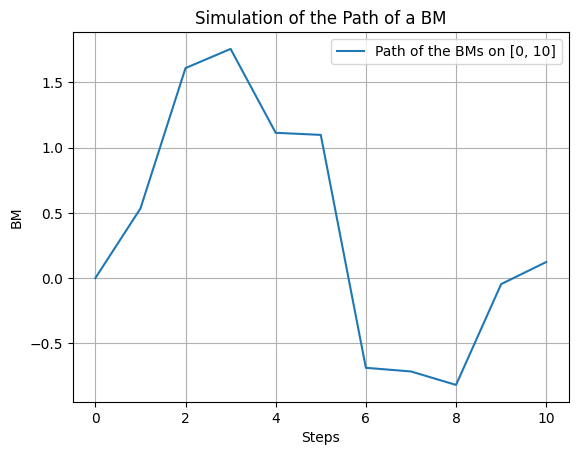

In [53]:
brownian_motion(10, 10)

In [54]:
# Given 10-day window of returns, predict direction of next-day return

def direction(returns):
    n = len(returns)
    directions = []
    for i in range(n-10):
        window = returns[i:i+10]
        positive = [1 if (window[j]/window[j-1]) - 1 > 0 for j in range(1, len(window))]
        if sum(positive) > len(window)//2:
            direction = "Up"
            directions.append(direction)
        else:
            directions.append("Down")
    return directions


SyntaxError: expected 'else' after 'if' expression (4073016356.py, line 8)

You’re given a list of integers and a number k. Return the k smallest elements in any order.


In [ ]:
import heapq

def smallest_1(nums, k):
    heap = []
    for num in nums:
        heapq.heappush(heap, num)
    return heap[:k]
    
# doesnt work because heap just ensures the first element is the smallest

def smallest(nums, k):
    heap = []
    for num in nums:
        heapq.heappush(heap, num)
    return [heapq.heappop(heap) for _ in range(k)]

smallest([51,3,6,2,7,9,1,77,11], 5)

[1, 2, 3, 6, 7]

Given a list of integers, return the k largest elements in any order.


In [57]:
# 1e version : too complicated and not efficient

def k_largest(nums, k):
    heap = []
    positive = [x for x in nums if x >= 0]
    negative = [x for x in nums if x not in positive]
    heap_1 = []
    heap_2 = []
    for num in nums:
        if num > 0:
            heapq.heappush(heap_1, -num)
        else:
            heapq.heappush(heap_2, num)
    m = len(heap_1)
    if m > k:
        return [-heapq.heappop(heap_1) for _ in range(k)]
    else:
        output = []
        for _ in range(m):
            output.append(-heappop(heap_1))
        for _ in range(k-m+1):
            output.append(heappop(heap_2[::-1]))
        return ouptut

k_largest([-1, 9, -72, -13, 5, 7, 6, 4, 3, 0, 11, 6, 45, 6, 8], 3)


# 2e verison

def k_largest_1(nums, k):
    min_heap = []
    for num in nums:
        heapq.heappush(min_heap, num)
        if len(min_heap) > k:
            heapq.heappop(min_heap)
    return min_heap

k_largest_1([-1, 9, -72, -13, 5, 7, 6, 4, 3, 0, 11, 6, 45, 6, 8], 3) 


[9, 11, 45]

Top K Frequent Elements

In [59]:
from collections import defaultdict, Counter

# First version : dictionnaries but sorting is O(nlog(n))

def k_frequent(nums, k):
    counts = Counter(nums)
    counts = sorted(counts, key = lambda x: -counts[x])
    return counts[:k]

# Second version : heap structure
# Problem : can lost which real keys are attached to the values in my min_heap

def k_frequent_1(nums, k):
    counts = Counter(nums)
    min_heap = []
    for key, val in counts.items():
        heapq.heappush(min_heap, val)
        if len(min_heap) > k:
            heapq.heappop(min_heap)
    return [key for key, val in counts.items() if val in min_heap]

# Third version 
# val before q before heap always compare the first element

def k_frequent_2(nums, k):
    counts = Counter(nums)
    min_heap = []
    for key, val in counts.items():
        heapq.heappush(min_heap, (val, key))
        if len(min_heap) > k:
            heapq.heappop(min_heap)
    return [key for val, key in min_heap]


(LC 215) Given an integer array nums and an integer k, return the kth largest element in the array.

In [60]:
def k_element(nums, k):
    max_heap = []
    for num in nums:
        heapq.heappush(max_heap, num)
        if len(max_heap) > k:
            heapq.heappop(max_heap)
    return max_heap[0]

(LC 1046) You are given a list of stones. Each turn, take the two heaviest stones, smash them together:

If they’re equal: both destroyed

If not: return the difference into the heap

Return the weight of the last stone (or 0 if none left)

In [61]:
# 1e version 

def last_stone(nums):
    liste = nums.copy()
    while len(liste) > 1:
        # we first get the two heaviest stones
        max_heap = []
        for num in liste:
            heapq.heappush(max_heap, num)
            if len(max_heap) > 2:
                heapq.heappop(max_heap)
        liste.remove(max_heap[0])
        liste.remove(max_heap[1])
        if max_heap[0] != max_heap[1]:
            liste.append(max_heap[1] - max_heap[0])
    if liste == []:
        return 0
    else:
        return liste[0]
        
        
# 2e version : heapify rearranges the list and ensures that everytime you access heap, the first element 
# will be the smallest.

def last_stone(nums): # all the stones are >= 0
    max_heap = [-num for num in nums]
    heapq.heapify(max_heap) # ensures max_heap contains the smallest element on top [0]
    while len(max_heap) > 1:
        stone_1 = -heapq.heappop(max_heap)
        stone_2 = -heapq.heappop(max_heap)
        if stone_1 > stone_2:
            heapq.heappush(max_heap, stone_2 - stone_1) # what we add must be negative
    return -max_heap[0] if max_heap else 0

Median from Data Stream (LeetCode 295)

In [ ]:
class MedianFinder:
    
    def __init__(self):
        self.nums = []

    def addNum(self, num:int) -> None:
        self.nums.append(num)

    def findMedian(self) -> float:
        liste = self.nums
        n = len(liste)
        if n%2 != 0:
            k = n//2 + 1
            # Now the goal is to find the k-th element of the list
            neg_heap = heapq.heapify([x for x in liste if x < 0])
            pos_heap = heapq.heapify([x for x in liste if x > 0])
            if len(neg_heap) > k:
                i = 0
                while i < k:
                    median = heapq.heappop(neg_heap)
                    i += 1
                return median
            else:
                i = 0
                while i < n-k:
                    median = heapq.heappop(pos_heap)
                    i += 1
                return median

(LC 239) Given an array nums and an integer k, return a list of the maximum values in each sliding window of size k.

In [62]:
# First idea : TLE 37/51

def sliding_window(nums, k):
    output = []
    n = len(nums)
    for i in range(n-k+1):
        window = nums[i:i+k]
        # Let's now get the max value of the list
        heapq.heapify(window) # window becomes a peap obj
        while len(window) > 1:
            heap.heappop(window)
        output.append(window[0])
    return output


(LC 703) Kth Largest Element in a Stream 

In [64]:
# 1e version
# max_heap -x always works for the max even if there positive anad negatives
# problem here is that at each adding, creation of a heap structure : not efficient when big dataset

class KthLargest:
    def __init__(self, k, nums):
        self.nums = nums # initial stream
        self.wanted = k
        
    def add(self, val) -> int:
        self.nums.append(val) # val is added to the stream
        k = self.wanted
        # now we want to return the k-th largest
        max_heap = []
        for num in self.nums:
            heapq.heappush(max_heap, -num)
        for _ in range(k-1):
            heapq.heappop(max_heap)
        return -max_heap[0]
            
# 2e version

class KthLargest1:
    def __init__(self, k, nums):
        self.k = k
        self.min_heap = []
        for num in nums:
            heapq.heappush(self.min_heap, num)
            if len(self.min_heap) > k: # ensures k elements in the heap with the smallest as first
                heapq.heappop(self.min_heap)

    def add(self, val) -> int:
        heapq.heappush(self.min_heap, val)
        if len(self.min_heap) > self.k:
            heapq.heappop(self.min_heap)
        return self.min_heap[0]

You are given an array ropes representing the length of ropes.
You can only connect two ropes at a time, and the cost is the sum of their lengths. Return the minimum total cost to connect all ropes into one

In [66]:
def cost(ropes):
    heapq.heapify(ropes) # ropes has a heap structure
    n = len(ropes)
    cost = 0
    while len(ropes) > 1:
        first = heapq.heappop(ropes)
        second = heapq.heappop(ropes)
        new = first + second
        cost += new
        heapq.heappush(ropes, new)
    return cost

Simulate asset prices using Geometric Brownian Motion (GBM)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def asset_prices(S0, mu, sigma, T, N):
    # [0, T] horizon
    # N number of subdivisions of [0, T]
    times = np.linspace(0, T, N+1)
    dt = T/N
    dB = np.random.normal(0, np.sqrt(dt), N)
    B = np.insert(np.cumsum(dB), 0, 0)
    S = S0 * np.exp((mu-0.5*sigma**2) * times + sigma * B)
    return S

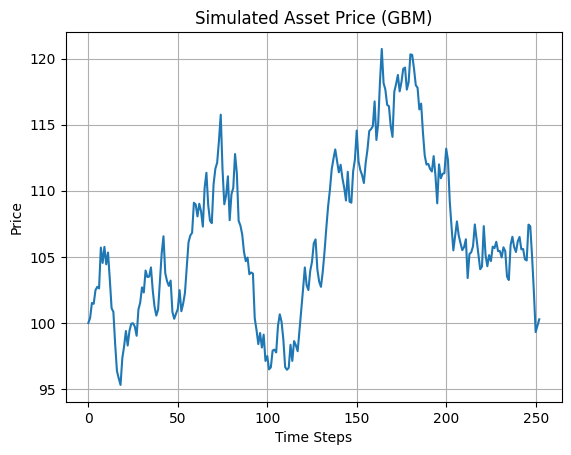

In [7]:
S = asset_prices(100, mu=0.05, sigma=0.2, T=1, N=252)

plt.plot(S)
plt.title("Simulated Asset Price (GBM)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()

We want to estimate the fair price of a European call option:

In [14]:
from scipy.stats import norm

def price_european_call(S, K, T, q, r, sigma):
    # S is the asset on which the option is based, T the time to maturity
    # The asset pays dividends continuously (rate q)
    d2 = (np.log(S/K) + (r - q - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    call_price = S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return call_price

def price_call_mc(S0, r, sigma, T, K, N): # C0 = exp(-rT) * E[max(ST-K, 0)] # No dividends here
    # N is the number of simulations of our MC method
    # Here, T is the maturity 
    B = np.random.normal(0, T, N)
    S_T = S0*np.exp((r-0.5*sigma**2)*T + sigma*B)
    X = np.maximum(S_T-K, 0)
    return np.exp(-r*T) * np.mean(X)

In [15]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 100_000
q = 0

theoretical_price = price_european_call(100, 100, 1, 0, 0.05, 0.2)
mc_price = price_call_mc(S0, r, sigma, T, K, N)
print(f"Theoretical Price = {theoretical_price:.2f}")
print(f"MC Call Price ≈ {mc_price:.2f}")

Theoretical Price = 10.45
MC Call Price ≈ 10.55


In [16]:
# Put-Call parity (with no dividends) : C - P = S -Kexp(-r(T-t))
# Let's see if its empirically verified

def price_put_mc(S0, r, sigma, T, K, N): # C0 = exp(-rT) * E[max(K-ST, 0)] # No dividends here
    # N is the number of simulations of our MC method
    # Here, T is the maturity 
    # We generate the normal laws differently from precedently
    B = np.random.normal(0, 1, N)
    S_T = S0*np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*B)
    X = np.maximum(K-S_T, 0)
    return np.exp(-r*T) * np.mean(X)

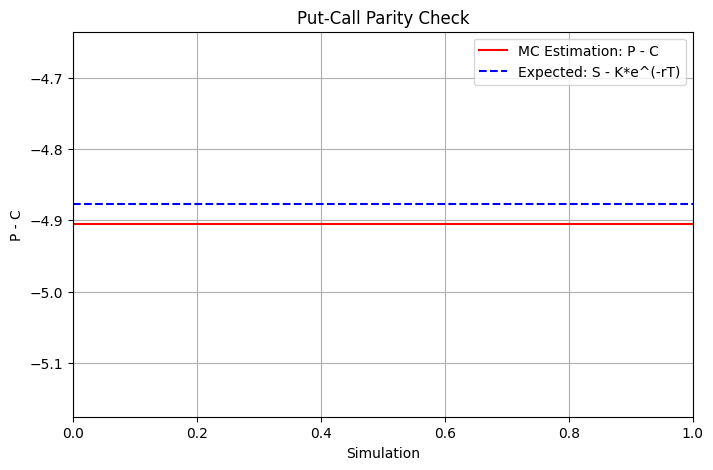

In [21]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 1000000
q = 0

P = price_put_mc(S0, r, sigma, T, K, N)
C = price_call_mc(S0, r, sigma, T, K, N)
expected = S0 - K*np.exp(-r*T)

# Plotting
plt.figure(figsize=(8, 5))
plt.axhline(y=P - C, color="red", label="MC Estimation: P - C")
plt.axhline(y=-expected, color="blue", linestyle="--", label="Expected: S - K*e^(-rT)")
plt.title("Put-Call Parity Check")
plt.xlabel("Simulation")
plt.ylabel("P - C")
plt.grid(True)
plt.legend()
plt.show()

We now want a 95% confidence interval of the estimate.

We want a,b such that a < call_mc < b = 0.95.

In [22]:
# We take a = 2.5% = 0.025 and b = 97,5% = 0.975
# price_mc_call = exp(-r(T-t)) * payoff

Z = np.random.normal(0, 1, N)
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
payoffs = np.maximum(S_T - K, 0)
discounted_payoffs = np.exp(-r * T) * payoffs # We have N payoffs because we have generated N standard gaussian

a = np.percentile(discounted_payoffs, 2.5)
b = np.percentile(discounted_payoffs, 97.5)

C_hat = np.mean(discounted_payoffs)

print(f"Monte Carlo estimate: {C_hat:.4f}")
print(f"95% CI: [{a:.4f}, {b:.4f}]")

Monte Carlo estimate: 10.4547
95% CI: [0.0000, 49.9281]


Task: Compute the Vega and Theta of a European Call Option via Monte Carlo

Approximate the Vega (sensitivity to volatility) and Theta (sensitivity to time) using finite differences and your Monte Carlo call pricing function.

Finite differences are used to estimate f'(x) bc f(x+eps) - f(x-eps) / 2eps  ~  f'(x) (Central difference)

(Backward difference) f'(x) ~ f(x) - f(x-eps) / eps 

(Forward difference)  f'(x) ~ f(x+eps) - f(x) / eps

In [25]:
def vega_approximation_call(S0, r, sigma, T, K, N, eps):
    # we first approximate C the price of a call option via MC simulation
    first_call = price_call_mc(S0, r, sigma + eps, T, K, N)
    second_call = price_call_mc(S0, r, sigma - eps, T, K, N)
    return (first_call - second_call) / (2*eps)

# Central finite difference approximation of Vega using two Monte Carlo estimates
# with vol shifts of ±ε. We prefer central over forward/backward for better accuracy.

def theta_approximation_call(S0, r, sigma, T, K, N, eps):
    first_call = price_call_mc(S0, r, sigma, T + eps, K, N)
    second_call = price_call_mc(S0, r, sigma, T, K, N)
    return (first_call - second_call) / (2*eps)

# For most Greeks, we use central differences for accuracy. For Theta, we might prefer backward 
# because we can’t go forward in time when T is small — you’d end up with negative time-to-maturity.
# Similarly, when T very close to maturity, we may go over it by adding eps.

Task : Simulate the Monte Carlo call price multiple times and plot the 95% confidence interval band over iterations

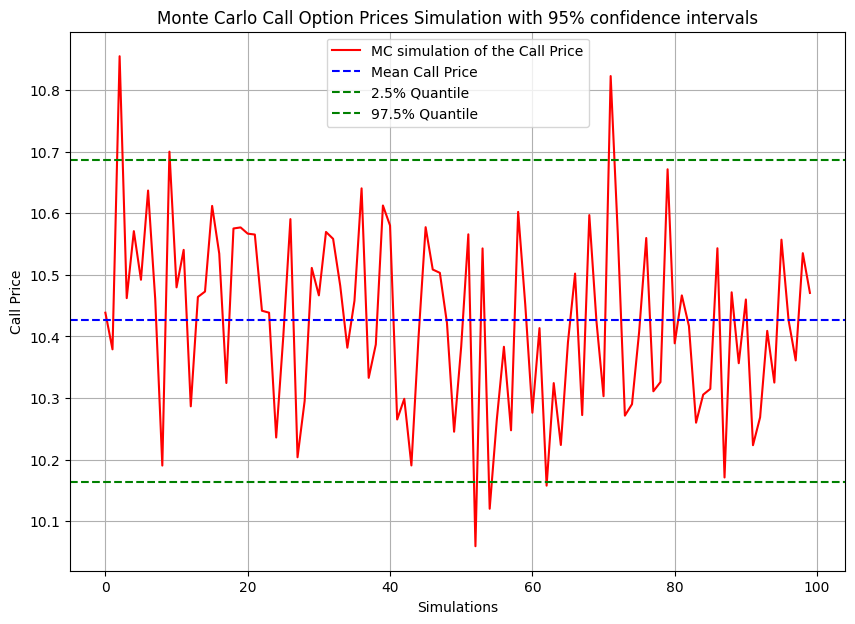

In [30]:
def mc_call_price(S0, r, sigma, T, K, N):
    B = np.random.normal(0, 1, N)
    S_T = S0 * np.exp( (r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*B)
    X = np.maximum(S_T - K, 0)
    payoff = np.mean(X)
    return np.exp(-r*T) * payoff

S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 10000

call_prices = []
for _ in range(100):
    call_price = mc_call_price(S0, r, sigma, T, K, N)
    call_prices.append(call_price)

# We now have a list of call_prices simulated by MC methods. 
# Each call_price in the list is one estimate of the true call option value (100 different estimations of the price).
# Let’s find a range of prices such that the true option price falls within that range 95% of the time.
# We used empirical quantiles for the confidence interval because it doesn't assume normality
# and is more robust to skew or heavy tails in the estimator's distribution.

mean_call_price = np.mean(call_prices)
left_side = np.quantile(call_prices, 0.025)
right_side = np.quantile(call_prices, 0.975)

# Plotting 

plt.figure(figsize=(10, 7))
plt.plot(call_prices, color="red", label="MC simulation of the Call Price")
plt.axhline(mean_call_price, color="blue", linestyle="--", label="Mean Call Price")
plt.axhline(left_side, color="green", linestyle="--", label="2.5% Quantile")
plt.axhline(right_side, color="green", linestyle="--", label="97.5% Quantile")
plt.xlabel("Simulations")
plt.ylabel("Call Price")
plt.title(f"Monte Carlo Call Option Prices Simulation with 95% confidence intervals")
plt.legend()
plt.grid(True)
plt.show()

For fixed parameters S0, r, sigma, T, simulate how the price of a European call option evolves as the strike price K varies.

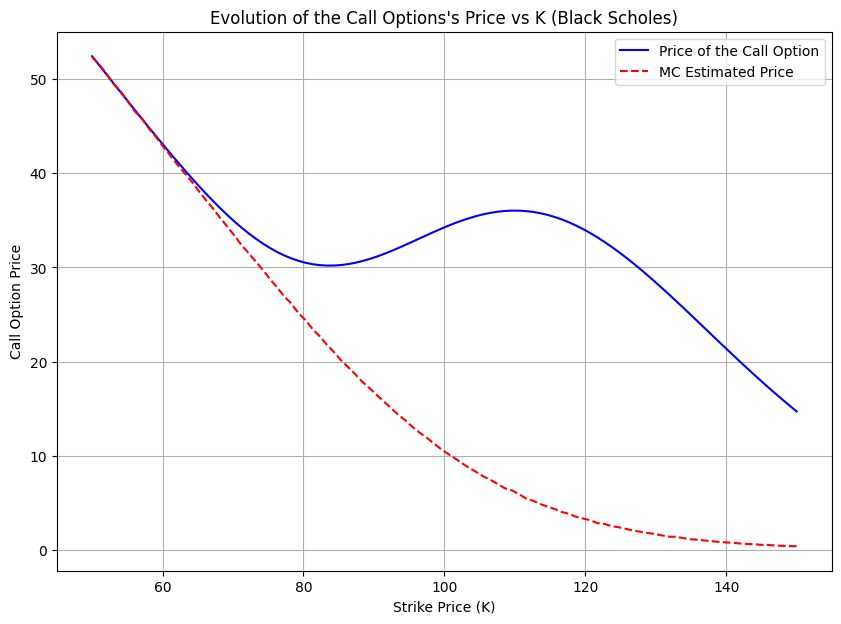

In [37]:
from scipy.stats import norm

def theoretical_call_price(S0, r, sigma, T, K): # There are no dividends here
    d2 = (np.log(S0/K) + (r-0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d1 = d2 + np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Let's now plot how this prices varies as a function of K

S0 = 100
r = 0.05
sigma = 0.2
T = 1

values_of_K = np.linspace(50, 150, 100)
prices = [theoretical_call_price(S0, r, sigma, T, K) for K in values_of_K]

plt.figure(figsize=(10, 7))
plt.plot(values_of_K, prices, color="blue", label="Price of the Call Option")
# Let's compare with the MC Call Pricer
prices_mc = [mc_call_price(S0, r, sigma, T, K, N=100_000) for K in values_of_K]
plt.plot(values_of_K, prices_mc, color="red", label="MC Estimated Price", linestyle="--")

plt.xlabel("Strike Price (K)")
plt.ylabel("Call Option Price")
plt.title("Evolution of the Call Options's Price vs K (Black Scholes)")
plt.grid(True)
plt.legend()
plt.show()

Task: Plot Greeks vs Parameters. You'll numerically compute and plot one Greek (like Delta or Vega) as a function of a varying parameter. Let's start with Delta vs S0.

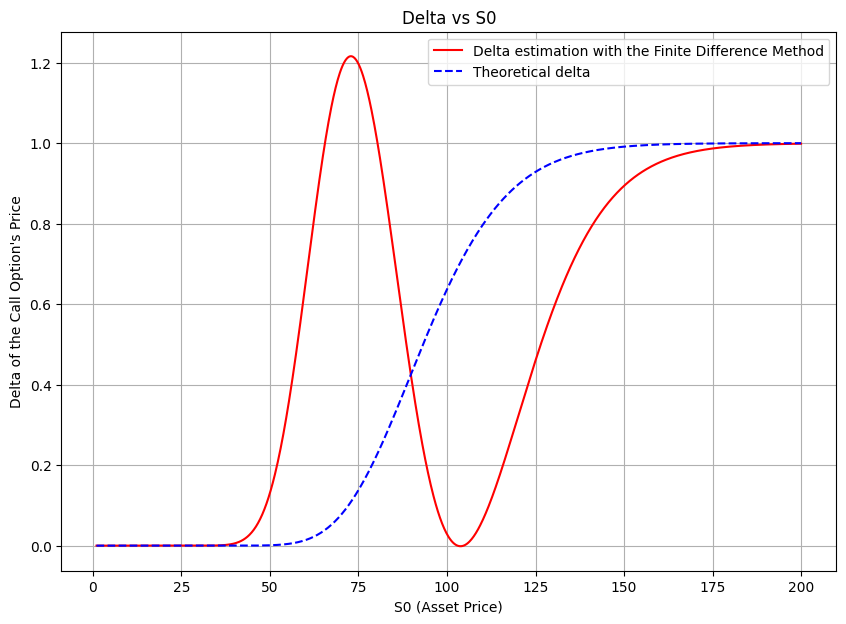

In [52]:
def finite_diff_delta(S0, r, sigma, T, K, eps):
    first_term = theoretical_call_price(S0 - eps, r, sigma, T, K)
    second_term = theoretical_call_price(S0 + eps, r, sigma, T, K)
    return (second_term - first_term) / (2*eps)

def theoretical_delta(S0, r, sigma, T, K):
    d1 = (np.log(S0/K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

# Plotting

eps = 0.0001
K = 100
r = 0.05
sigma = 0.2
T = 1

S0 = np.linspace(1, 200, 1000)
deltas = [finite_diff_delta(price, r, sigma, T, K, eps) for price in S0]
theoretical_deltas = [theoretical_delta(price, r, sigma, T, K) for price in S0]


plt.figure(figsize=(10,7))
plt.plot(S0, deltas, color="red", label="Delta estimation with the Finite Difference Method")
plt.plot(S0, theoretical_deltas, color="blue", linestyle="--", label="Theoretical delta")
plt.xlabel("S0 (Asset Price)")
plt.ylabel("Delta of the Call Option's Price")
plt.title("Delta vs S0")
plt.legend()
plt.grid(True)
plt.show()

There is a spike at 75 :(((  Delta itself changes non-linearly near ATM (when S0 ~ K) so even tiny shifts in  S0 can cause large changes in price and hence larger "bumps" in estimated Delta

Task : Simulation and Plotting of M brownian motions on [0, T]

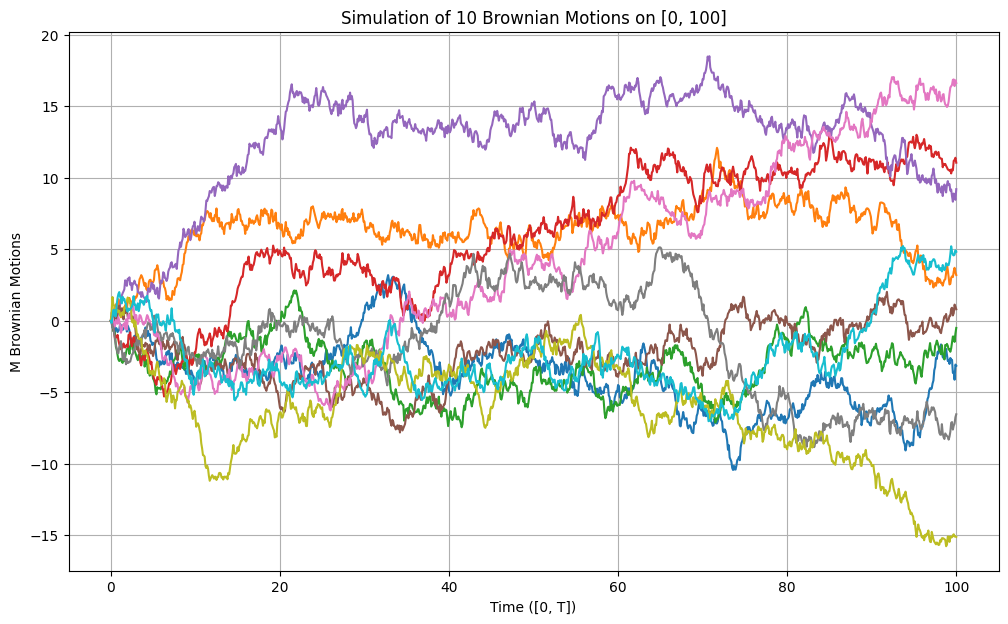

In [73]:
def brownian_motions(T, N, M):
    times = np.linspace(0, T, N+1) # from 0 to N (N+1 points)
    dt = T/N
    dB = np.random.normal(0, np.sqrt(dt), (M,N))
    B = np.zeros((M, N+1))
    B[:, 1:] = np.cumsum(dB, axis = 1) # fill B with the Brownian motions (summed by columns so summed row-wised)
    plt.figure(figsize=(12, 7))
    for i in range(M): # plot each BM 
        plt.plot(times, B[i], label=f"Brownian Motion {i}")
    plt.xlabel("Time ([0, T])")
    plt.ylabel("M Brownian Motions")
    plt.title(f"Simulation of {M} Brownian Motions on [0, {T}]")
    plt.grid(True)
    plt.show()

brownian_motions(100, 1000, 10)

"Given a time series of prices, build a classifier that predicts whether the next-day return will be positive or negative."

In [81]:
def generate_prices(n, mu, sigma): 
    # Generate a list of n prices when the prices follow a GBM dynamics with drift mu and volatility sigma 
    # S(t+1) = S(t) * exp(mu + sigma*U) where U ~ N(0, 1)
    # S(t+1) = S(t) * exp(V) where V ~ N(mu, sigma)
    prices = [100]*n
    for i in range(1,n):
        noise = np.random.normal(mu, sigma)
        prices[i] = prices[i-1]*np.exp(noise)
    return prices

def generate_returns(prices):
    # Generate a list of returns based on a time series prices of length n (returns is of length n-1)
    n = len(prices)
    returns = [0]
    returns += [prices[i] / prices[i-1] - 1 for i in range(1,n)]
    return returns 

Let’s say you want to use past 10 returns to predict the direction of the next return

In [82]:
# Let's now generate our data

def data_simulation(n, mu, sigma, window=10): # going to use a list of n prices to generate data
    X, y = [], []
    prices = generate_prices(n, mu, sigma)
    returns = generate_returns(prices)
    for i in range(n-window):
        data = returns[i:i+window]
        X.append(data)
        label = returns[i+window]
        if label > 0:
            y.append(1)
        else:
            y.append(0)
    return np.array(X), np.array(y)

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

X, y = data_simulation(300, 0.05, 0.2, window=10) # 5% interest rate, 20% volatility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(predictions, y_test)
precision = precision_score(predictions, y_test)
confusion = confusion_matrix(predictions, y_test)

In [86]:
print(f"The accuracy of our model is {accuracy :.2f}")
print(f"The confusion matrix is {confusion }")
print(f"The precision of our model is {precision :.2f}")

The accuracy of our model is 0.62
The confusion matrix is [[ 3  8]
 [25 51]]
The precision of our model is 0.86


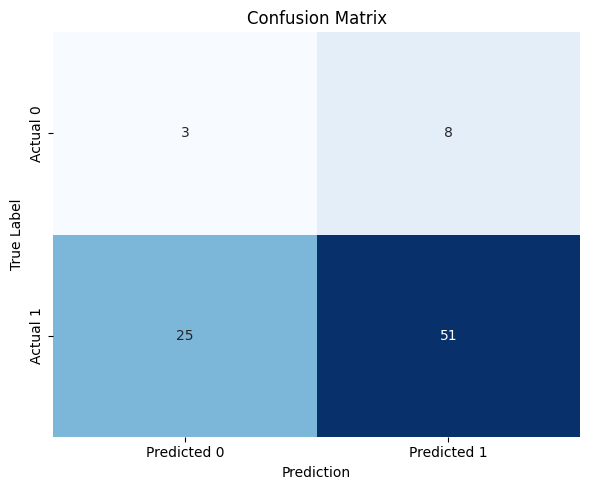

In [87]:
import seaborn as sns

# Plotting
plt.figure(figsize=(6,5))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [88]:
from sklearn.ensemble import RandomForestClassifier

model_1 = RandomForestClassifier()
model_1.fit(X_train, y_train)
predictions_1 = model_1.predict(X_test)

accuracy_1 = accuracy_score(predictions_1, y_test)
precision_1 = precision_score(predictions_1, y_test)
confusion_1 = confusion_matrix(predictions_1, y_test)

In [89]:
print(f"The accuracy of our model is {accuracy_1 :.2f}")
print(f"The confusion matrix is {confusion_1 }")
print(f"The precision of our model is {precision_1 :.2f}")

The accuracy of our model is 0.57
The confusion matrix is [[ 8 17]
 [20 42]]
The precision of our model is 0.71


Even worse, bc i haven't focused on the distribution of the data (it is unbalanced)

In [90]:
model_2 = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model_2.fit(X_train, y_train)
predictions_2 = model_2.predict(X_test)

accuracy_2 = accuracy_score(predictions_2, y_test)
precision_2 = precision_score(predictions_2, y_test)
confusion_2 = confusion_matrix(predictions_2, y_test)

In [91]:
print(f"The accuracy of our model is {accuracy_2 :.2f}")
print(f"The confusion matrix is {confusion_2 }")
print(f"The precision of our model is {precision_2 :.2f}")

The accuracy of our model is 0.54
The confusion matrix is [[ 6 18]
 [22 41]]
The precision of our model is 0.69


In [94]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize and train the model
model_3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_3.fit(X_train, y_train)

# Predictions
predictions_3 = model_3.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, predictions_3))
print(classification_report(y_test, predictions_3))

[[10 18]
 [22 37]]
              precision    recall  f1-score   support

           0       0.31      0.36      0.33        28
           1       0.67      0.63      0.65        59

    accuracy                           0.54        87
   macro avg       0.49      0.49      0.49        87
weighted avg       0.56      0.54      0.55        87



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:45:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


LEARNING TREE BFS DFS


In [96]:
def counting_nodes(tree): # how many nodes in the tree
    # tree has been created with root = TreeNode(..) ....
    # Each node is an object (TreeNode) with .left and .right as potential children
    if not tree:
        return 0
    count = 0
    queue = deque([tree]) # Adds the initial node
    while queue: # While the queue is not empty
        node = queue.popleft() # we empty queue from this node and we count it
        count += 1
        if node.left: # If the node has a left child, we add it to the queue
            queue.append(node.left)
        if node.right: # If the node has a right child, we add it to queue
            queue.append(node.right)
    return count

Write a function sum_nodes(tree) that returns the sum of all node values in the tree.

In [97]:
def sum_nodes(tree):
    if not tree:
        return 0
    somme = 0
    queue = deque([tree]) # The parental node is added to queue
    while queue:
        node = queue.popleft()
        somme += node.val
        if node.left:
            queue.append(node.left)
        if node.right:
            queue.append(node.right)
    return somme

Return how many nodes in the tree have an even value

In [99]:
def even_nodes(tree):
    if not tree:
        return 0
    queue = deque([tree])
    even = 0
    while queue:
        node = queue.popleft()
        if node.val % 2 == 0:
            even += 1
        if node.left:
            queue.append(node.left)
        if node.right:
            queue.append(node.right)
    return even

Find the maximum value in the tree

In [100]:
def maximum_tree(tree):
    if not tree:
        return 0
    maximum = float('-inf')
    queue = deque([tree])
    while queue:
        node = queue.popleft()
        maximum = max(maximum, node.val)
        if node.left:
            queue.append(node.left)
        if node.right:
            queue.append(node.right)
    return maximum

Compute the Maximum Depth (number of levels) of the Tree

In [ ]:
# First version : false

def max_depth(tree):
    if not tree:
        return 0
    depth = 1
    queue = deque([tree])
    while queue:
        node = queue.popleft()
        if node.left and not node.right:
            queue.append(node.left)
            depth += 1
        elif node.right and not node.left:
            queue.append(node.right)
            depth += 1
        elif node.left and node.right:
            queue.append(node.left)
            queue.append(node.right)
            depth += 1
    return depth

In [101]:
def max_depth(tree):
    if not tree:
        return 0
    queue = deque([tree])
    depth = 0
    while queue:
        current_size = len(queue)
        for _ in range(current_size):
            node = queue.popleft()
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
        depth += 1
    return depth

Return the node values at the deepest level

In [102]:
def deepest_level(tree):
    if not tree:
        return []
    values = []
    queue = deque([tree])
    while queue:
        current_size = len(queue)
        current_level = []
        for _ in range(current_size):
            node = queue.popleft()
            current_level.append(node.val)
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
        values = current_level # keep track of the last levem
    return values

Count the number of leaf nodes in a binary tree (leaf nodes i no children)

In [103]:
def leaf_nodes(tree):
    if not tree:
        return 0
    leaf = 0
    queue = deque([tree])
    while queue:
        current_size = len(queue)
        for _ in range(current_size):
            node = queue.popleft()
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
            if not node.left and not node.right:
                leaf += 1
    return leaf

(LC 102 medium) Given the root of a binary tree, return the level order traversal of its nodes’ values.
(i.e., from left to right, level by level)

In [104]:
def traversal(tree):
    if not tree:
        return []
    traversal = []
    queue = deque([tree])
    while queue:
        current_size = len(queue)
        current_level = []
        for _ in range(current_size):
            node = queue.popleft()
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
            current_level.append(node.val)
        traversal.append(current_level)
    return traversal

(LC 111 easy) Given a binary tree, return its minimum depth. The minimum depth is the number of nodes along the shortest path from the root node down to the nearest leaf node. A leaf is a node with no children.

In [105]:
def minimum_depth(tree):
    if not tree:
        return 0
    min_depth = 1
    queue = deque([tree])
    while queue:
        current_size = len(queue)
        for _ in range(current_size):
            node = queue.popleft()
            if not node.left and not node.right:
                return min_depth
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
        min_depth += 1
    return min_depth

(LC 103 medium) Given a binary tree, return the zigzag level order traversal of its nodes’ values.

In [106]:
def zigzag(tree):
    if not tree:
        return []
    queue = deque([tree])
    traversal = []
    while queue:
        current_size = len(queue)
        current_level = []
        for _ in range(current_size):
            node = queue.popleft()
            if node.left:
                queue.append(node.left)
            if node.right:
                queue.append(node.right)
            current_level.append(node.val)
        traversal.append(current_level)
    m = len(traversal)
    for i in range(1, m, 2):
        traversal[i] = traversal[i][::-1]
    return traversal

(LC 226 easy)

In [108]:
def inverted_tree(tree):
    if not tree:
        return []
    inverted = []
    queue = deque([tree])
    while queue:
        current_size = len(queue)
        current_level = []
        for _ in range(current_size):
            node = queue.popleft()
            if node.left and node.right:
                node.left, node.right = node.right, node.left
                queue.append(node.left)
                queue.append(node.right)
            elif node.left:
                queue.append(node.left)
            elif node.right:
                queue.append(node.right)
            current_level.append(node.val)
        inverted.append(current_level)
    return inverted

The previous code isn't satisfying bc what is asked is to return an inverted tree, not a list of lists.

In [109]:
def inverted_tree(tree):
    if not tree:
        return None
    queue = deque([tree])
    while queue:
        node = queue.popleft()
        node.left, node.right = node.right, node.left
        if node.left:
            queue.append(node.left)
        if node.right:
            queue.append(node.right)
    return tree

Monte Carlo estimation of π

In [ ]:
def pi_estimation(n): 
    # [-1, 1] x [-1, 1] is a square of area 4
    # A = {(x, y) in [-1, 1]^2 st x**2 + y**2 <= 1} the circle unit inscribed in that square has area of 1
    X = np.random.unif([-1, 1]*[-1, 1], n)
    A = (x**2 + y**2 <= 1 for x,y in X)
    return 4*A / n

In [ ]:
def pi_estimation(n): 
    # [-1, 1] x [-1, 1] is a square of area 4
    # A = {(x, y) in [-1, 1]^2 st x**2 + y**2 <= 1} the circle unit inscribed in that square has area of 1
    x = np.random.rand(-1, 1, n)
    y = np.random.rand(-1, 1, n)
    A = np.sum(x**2 + y**2 <= 1)
    return 4*A / n

In [ ]:
def price_simulation(n, S0, sigma, mu): # n the number of days
    prices = [S0]*n
    for i in range(1, n):
        prices[i] = prices[i-1]*np.exp(mu + sigma*np.random.normal(0, 1))
    return prices

def strategy(prices):
    strategy = []
    n = len(prices)
    returns = [0] + [prices[i] / prices[i-1] - 1 for i in range(n)]
    for i in range(len(returns)-5+1):
        if np.mean(returns[i:i+5]) > 0:
            strategy.append(1)
        else:
            strategy.append(0)
    return strategy

n = 252
S0 = 100
mu = 0.0005
sigma = 0.01

prices = price_simulation(n, S0, mu, sigma)
strategy = strategy(prices)
portfolio_value = []
for _ in range(len(prices)-5+1):
    if strategy[i] > 1:
        value = 

You're given a list of asset prices over n days. Write a function that identifies all "local maxima" — a local maximum is a day where the price is higher than the day before and the day after.
📌 Return a list of tuples containing the day index and the corresponding price.



In [2]:
from collections import defaultdict

def local_maxima(prices):
    n = len(prices)
    tuples = []
    for i in range(1,n-1):
        if prices[i] > max(prices[i-1], prices[i+1]):
            tuples.append((i, prices[i]))
    return tuples

In [11]:
def estimation_pi(n): # n is the number of simulation of our monte carlo methods
    x = np.random.uniform(-1, 1, n)
    y = np.random.uniform(-1, 1, n)
    # (x**2 + y**2 <= 1) : return a list of n booleans (True if x[i]**2 + y[i]**2 <= 1, False else)
    A = np.sum(x**2 + y**2 <= 1)
    return 4*A / n

/var/folders/h3/l62xkv5n0nv0zw9dvcbq_gww0000gn/T/ipykernel_63271/3155126119.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


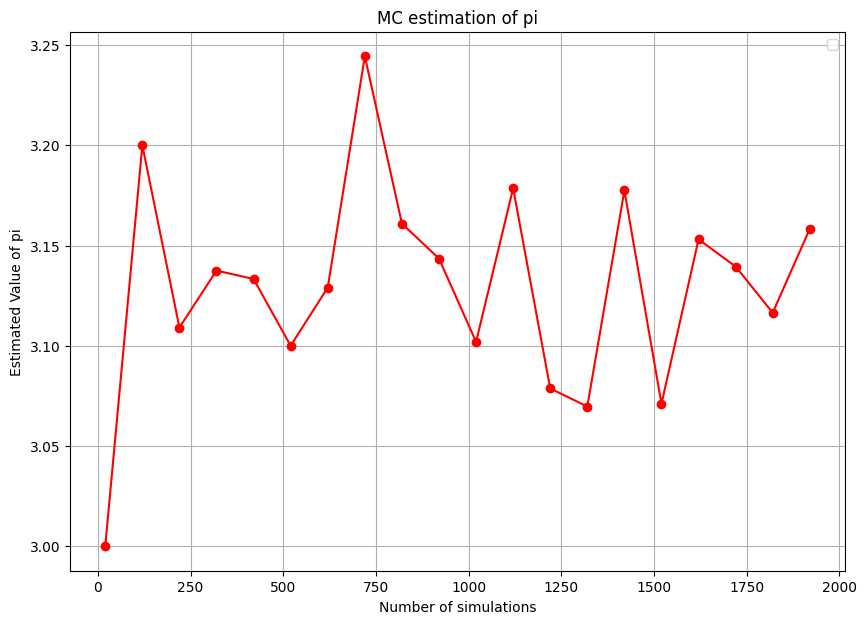

In [17]:
import matplotlib.pyplot as plt

estimated_values = []
number_of_simulations = []
for n in range(20, 2000, 100):
    value = estimation_pi(n)
    estimated_values.append(value)
    number_of_simulations.append(n)
plt.figure(figsize=(10, 7))
plt.plot(number_of_simulations, estimated_values , color="red", marker="o")
plt.xlabel("Number of simulations")
plt.ylabel("Estimated Value of pi")
plt.title("MC estimation of pi")
plt.grid(True)
plt.legend()
plt.show()

MC estimation of ln(2).

We first notice that ln(2) = integral from 0 to 1 of 1/(1+x). We are going to use the Riemann sum of integrals.

In [19]:
def function(x): # x is a NumPy array here
    return 1 / (1 + x)
    
def ln_estimation(n):   # n number of estimations
    points = np.random.uniform(0, 1, n)
    sample = function(points)
    return np.mean(sample)

MC estimation of integral of 0 to 1 of exp(-x^2)

In [ ]:
def exp_estimation(n):
    points = np.random.uniform(0, 1, n)
    sample = np.exp(-points**2)
    return np.mean(sample)

You’re given a list of stock prices where prices[i] is the price of a given stock on day i.
Write a function to find the maximum profit you can achieve from a single buy and a single sell.
You must buy before you sell. If you can’t make any profit, return 0

In [20]:
def max_profit(prices):
    n = len(prices)
    max_profit = 0
    min_price = prices[0]
    for i in range(1, n):
        current_profit = prices[i] - min_price
        if current_profit > max_profit:
            max_profit = current_profit
        if prices[i] < min_price:
            min_price = prices[i]
    return max_profit

The following is the same task but this time, we can buy and sell at any time. The following version is false bc I tried to replicate the previous strategy.

In [21]:
def max_profit_2(prices):
    n = len(prices)
    min_price = prices[0]
    profit = 0
    for i in range(1, n):
        current_profit = prices[i] - min_price
        if current_profit > 0:
            profit += current_profit
        if prices[i] > min_price:
            min_price = prices[i]
    return profit

The following version of the code is good.

In [22]:
def max_profit_2(prices):
    n = len(prices)
    profit = 0
    for i in range(1, n):
        if prices[i] > prices[i-1]:
            profit += prices[i] - prices[i-1]
    return profit

Problem: Estimate the Probability that a Brownian Motion Crosses a Barrier
Simulate N paths of a standard Brownian motion Bt on the interval [0, T] (T=1), and estimate the probability that at any time t in [0, T], the process exceeds a barrier level L (L=1.5).

In [23]:
def barrier_simulation(M, N, T): # N : Number of simulated paths 
    # M number of subdivisons of [0, T] (discretization of the [0, T] interval)
    # T : Horizon
    times = np.linspace(0, T, M+1) # from 0 to M (M+1 points)
    dt = T/M
    dB = np.random.normal(0, np.sqrt(dt), (N, M))
    B = np.zeros((N, M+1))
    B[:, 1:] = np.cumsum(dB, axis=1)
    higher = 0
    for i in range(N):
        for j in range(M+1):
            if B[i][j] > 1.5:
                higher += 1
                break
    return higher / N

# vectorized way would have been more efficient
# crossed = np.any(B > barrier, axis=1)
# return np.mean(crossed)

Simulate the asset price using a geometric Brownian motion, and return the Monte Carlo estimate of the digital call price. A digital call option pays $1 at maturity only if the asset price exceeds the strike price K, otherwise it pays $0. Here, N is the number of MC simulations.

In [1]:
def price_digital_call_mc(S0, K, r, sigma, T, N):
    # Simulation of the Brownian Motion
    B = np.random.normal(0, np.sqrt(T), N)
    S = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*B)
    payoff = (S > K).astype(int)
    return np.exp(-r*T)*np.mean(payoff)

Binary Barrier Digital Call — Breakdown

Price an option that pays $1 if:

The asset price touches a barrier (e.g., 120) at any time before maturity T

AND finishes above a strike price K at maturity

In [3]:
def barrier_digital(S0, K, r, sigma, T, N, M, H):
    # M is the number of subdivisions of [0, T]
    # H is the barrier
    # S follows a geometric Brownian Motion
    times = np.linspace(0, T, M+1)
    dt = T/N
    dB = np.random.normal(0, np.sqrt(dt), (N,M))
    B = np.zeros((N, M+1))
    B[:, 1:] = np.cumsum(dB, axis=1)
    # We now have N simulations of the asset's price evolution
    S = S0 * np.exp((r - 0.5*sigma**2)*times + sigma*B)
    final_above = S[:, -1] > K
    touched_barrier = np.max(S, axis=1) >= H
    payoff = (final_above & touched_barrier).astype(int)
    return np.exp(-r*T) * np.mean(payoff)

Basket digital call option
You hold a derivative that pays 1 at maturity if the average price of two assets at maturity is greater than a strike K, and 0 otherwise.

In [4]:
def payoff_correlated_assets(S1_0, S2_0, mu_1, mu_2, sigma_1, sigma_2, K, T, N, M):
    # M is the number of subdivisions of [0, T]
    # We first simulate two correlated Brownian motions
    times = np.linspace(0, T, M+1)
    dt = T/M
    dZ1 = np.random.normal(0, np.sqrt(dt), (N, M))
    dZ2 = np.random.normal(0, np.sqrt(dt), (N,M))
    dB1 = dZ1
    dB2 = rho*dZ1 + np.sqrt(1 - rho**2)*dZ2
    B1 = np.zeros((N, M+1))
    B2 = np.zeros((N, M+1))
    B1[:, 1:] = np.cumsum(dB1, axis=1)
    B2[:, 1:] = np.cumsum(dB2, axis=1)
    S1 = S1_0 * np.exp((mu_1 - 0.5*sigma_1**2)*times + sigma_1*B1)
    S2 = S2_0 * np.exp((mu_2 - 0.5*sigma_2**2)*times + sigma_2*B2)
    constraint = S1[:, -1] + S2[:, -1] > 2*K
    payoff = constraint.astype(int)
    return np.exp(-r*T) * np.mean(payoff)

❓ How does correlation ρ impact the option value?
➤ Higher ρ → more likely both assets rise together → higher basket payoff probability.

❓ What if the basket had weights?
➤ Replace average with w1 * S1 + w2 * S2, normalize weights.

Task: Detect “Local Bottoms” in Price Series (Mini Technical Test)

You’re given a list of prices. A local bottom is a point where the price is strictly lower than both its immediate neighbors (like a dip). Your task:

Given a Pandas Series prices, return a list of tuples (i, price) for each local bottom.

Then, create a new column in the DataFrame marking 1 at those points and 0 elsewhere (binary label).

In [7]:
import pandas as pd

def local_bottom(prices_list):
    n = len(prices_list)
    bottoms = []
    for i in range(1, n-1):
        if prices_list[i] < min(prices_list[i-1], prices_list[i+1]):
            bottoms.append((i, prices_list[i]))
    return bottoms

prices_list = [100, 98, 102, 99, 101, 97, 96, 98, 99]
prices_df = pd.DataFrame({'Price' : prices_list})
bottoms_idx = local_bottom(prices_list)
indexes = [i for (i, _) in bottoms_idx ]
prices_df['Bottom'] = [1 if i in indexes else 0 for i in range(len(prices_df))]
print(prices_df)


   Price  Bottom
0    100       0
1     98       1
2    102       0
3     99       1
4    101       0
5     97       0
6     96       1
7     98       0
8     99       0


OTHER TASK (Interview simulation)

You have a DataFrame df with columns: "Date", "Asset", "Price", "Volume", and "Returns". Some values in "Price" and "Returns" are missing.

✳️ You need to:

Fill missing "Price" values forward (using ffill)

Fill missing "Returns" values using the mean return per asset (grouped)

In [ ]:
# First version : not efficient bc pandas has more efficient tools

data = pd.DataFrame(df)

# Fill missing price values
prices = data['Price']
mean_price = np.mean(prices)
for i in range(len(data)):
    if prices[i] == 'NaN':
        prices[i] = mean_price

# Compute the returns per asset
assets = data['Asset']
mean_returns = defaultdict(int)
for asset in assets:
    return_sum = np.sum([data[data['Asset'] == asset]['Returns']])
    mean_returns[asset] = np.mean(return_sum)
for asset in assets:
    if data[data['Asset'] == asset]["Returns"] == 'NaN':
        data[data['Asset'] == asset]["Returns"] = mean_returns[asset]

In [ ]:
data = pd.DataFrame(df)

data['Price'] = data['Price'].ffill()
# .ffill() fills missing values with the last known non-null value (forward fill)

# .groupby('Asset')['Returns'].transform(...) applies the group mean back to the original DataFrame shape, 
# allowing you to fill missing returns based on their asset group.

🎯 Your task:
Fill missing Price values with the mean price of the corresponding asset.

Fill missing Return values with the mean return of the same asset.

Add a new column called "Direction":

1 if the return > 0

0 if the return ≤ 0

In [10]:
import numpy as np
import pandas as pd

data = pd.DataFrame({
    "Asset": ["AAPL", "AAPL", "AAPL", "MSFT", "MSFT", "GOOG", "GOOG"],
    "Price": [150, np.nan, 155, 250, np.nan, 1000, np.nan],
    "Return": [0.01, np.nan, 0.02, 0.015, np.nan, -0.005, np.nan]
})

# data['Price'] = data['Price'].fillna(data['Price'].mean()) # fill nan value with the mean (if there was ONE asset)

data['Price'] = data.groupby('Asset')['Price'].transform(lambda x : x.fillna(x.mean()))
data['Return'] = data.groupby('Asset')['Return'].transform(lambda x : x.fillna(x.mean()))
data['Direction'] = (data['Return'] > 0).astype(int)

data


,Asset,Price,Return,Direction
0,AAPL,150.0,0.010,1
1,AAPL,152.5,0.015,1
2,AAPL,155.0,0.020,1
3,MSFT,250.0,0.015,1
4,MSFT,250.0,0.015,1
5,GOOG,1000.0,-0.005,0
6,GOOG,1000.0,-0.005,0


You are given a dataframe with daily price data for multiple assets. Your task is to:

🎯 Goal:
Compute the daily return for each asset.

For each asset, compute the 7-day rolling average of the return.

For each asset, compute the 7-day rolling volatility (i.e., standard deviation) of the return.

Drop the first 6 rows per asset (since their rolling windows are incomplete).

Add a label column called "Volatile" which is 1 if the 7-day rolling volatility is above 2%, else 0.

In [11]:
import pandas as pd
import numpy as np

np.random.seed(42)

dates = pd.date_range("2024-01-01", periods=30)
assets = ["AAPL", "MSFT", "GOOG"]

# Expand the data
data = pd.DataFrame({
    "Date": np.tile(dates, len(assets)),
    "Asset": np.repeat(assets, len(dates)),
    "Price": np.random.normal(100, 5, len(dates)*len(assets))
})

data

,Date,Asset,Price
0,2024-01-01,AAPL,102.483571
1,2024-01-02,AAPL,99.308678
2,2024-01-03,AAPL,103.238443
3,2024-01-04,AAPL,107.615149
4,2024-01-05,AAPL,98.829233
...,...,...,...
85,2024-01-26,GOOG,97.491215
86,2024-01-27,GOOG,104.577011
87,2024-01-28,GOOG,101.643756
88,2024-01-29,GOOG,97.351199


🧠 What you need to do:
Group by asset ✅

Sort by date (important!) 🕒

Compute % daily return per asset and add it as a new column "Daily_Return" 📈

Fill the first row of each asset with 0 (no return on first day)

In [14]:
data = sorted(data, key = lambda x : x['Date'])

data['Daily_Return'] = 0

for asset in assets:
    indexes = data[data['Asset'] == asset].index # Get the indexes of lines of this asset
    prices = data.loc[indexes, 'Price'].values
    returns = [0]
    for i in range(1, len(prices)):
        rate = prices[i] / prices[i-1] - 1
        returns.append(rate)
    data.loc[indexes, 'Daily_Return'] = returns

One liner of all that behind :

In [15]:
data.sort_values(by=['Asset', 'Date'])
data['Daily_Return'] = data.groupby('Asset')['Price'].pct_change().fillna(0) # first rate always 0

Task: Detect Sudden Spikes in Volatility
You’re given a price dataset for multiple assets.

🔧 What to Do:
Compute daily returns per asset.

Compute 5-day rolling volatility per asset.
Formula: standard deviation of the last 5 daily returns.

Flag any day where the rolling volatility exceeds 3x the rolling mean volatility for that asset.

What to Submit (You’ll code it):
A new column: "Rolling_Volatility"

A new column: "Anomaly" with:

1 if current volatility > 3× avg rolling volatility

0 otherwise

In [ ]:
# .reset_index(0, drop=True) aligns indices back to the original frame

data = pd.DataFrame(df)
data['Daily_Return'] = data.groupby('Asset')['Price'].pct_change()
data['Rolling_Volatility'] = data.groupby('Asset')['Daily_Return'].rolling(window=5).std().reset_index(0, drop=True)
data['Rolling_Mean_Volatility'] = data.groupby('Asset')['Rolling_Volatility'].rolling(window=5).mean().rest_index(0, drop=True)
data['Anomaly'] = (data['Rolling_Volatility'] > 3*data['Rolling_Mean_Volatility']).astype(int)

You're given a dataset of asset prices over time (data) with columns:

'Date' (datetime)

'Asset' (string)

'Price' (float)

👉 Your goal:

Compute daily returns per asset

Calculate the standard deviation of returns per asset

Identify the asset with the highest return volatility

Plot the price evolution of that asset over time

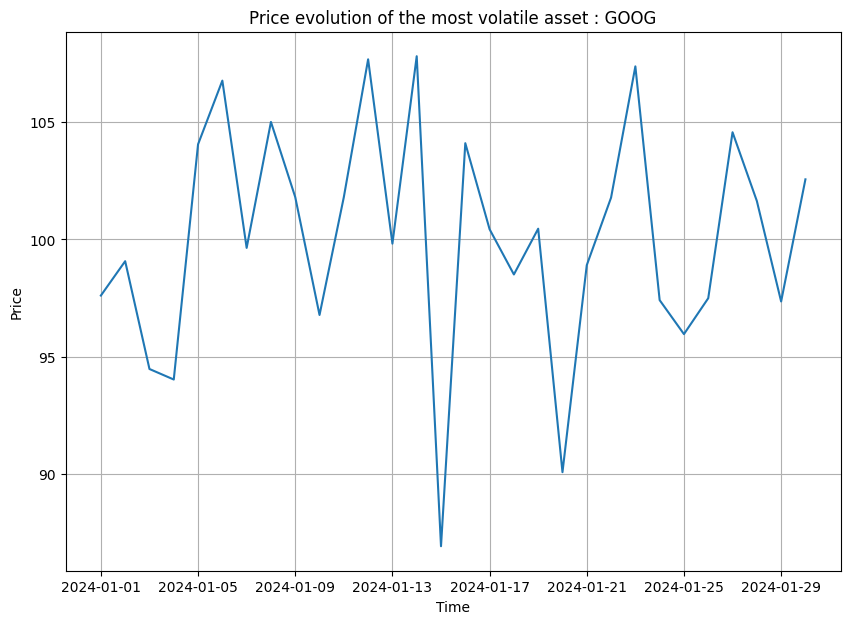

In [21]:
import matplotlib.pyplot as plt

np.random.seed(42)

times = pd.date_range("2024-01-01", periods=30)
assets = ["AAPL", "MSFT", "GOOG"]

# Expand the data
data = pd.DataFrame({
    "Time": np.tile(dates, len(assets)),
    "Asset": np.repeat(assets, len(dates)),
    "Price": np.random.normal(100, 5, len(dates)*len(assets))
})

data['Daily_Return'] = data.groupby('Asset')['Price'].pct_change()
volatility_per_asset = data.groupby('Asset')['Daily_Return'].std()
most_volatile_asset = volatility_per_asset.idxmax()
# idxmax works here before after groupby, we have a series Asset    Daily_Return and the index is Asset

# Filter the data for this asset
asset_data = data[data['Asset'] == most_volatile_asset]

plt.figure(figsize=(10, 7))
plt.plot(asset_data['Time'], asset_data['Price'])
plt.xlabel("Time")
plt.ylabel("Price")
plt.title(f"Price evolution of the most volatile asset : {most_volatile_asset}")
plt.grid(True)
plt.show()

NEW TASK


In [24]:
import pandas as pd

df = pd.read_csv('fake_financial_data.csv')

data

,Date,Asset,Price,Volume
0,2024-01-01,AAPL,100.993428,4104
1,2024-01-02,AAPL,100.716900,8215
2,2024-01-03,AAPL,102.012277,3454
3,2024-01-04,AAPL,105.058336,9996
4,2024-01-05,AAPL,104.590030,3731
...,...,...,...,...
295,2024-03-18,TSLA,100.592973,2761
296,2024-03-19,TSLA,100.389074,1876
297,2024-03-20,TSLA,100.473343,4812
298,2024-03-21,TSLA,101.502521,2460


In [28]:
# Compute Daily Returns for Each Asset
df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()

# Fill Missing Volume Values per Asset (fill them with the mean value per asset)
df['Volume'] = df.groupby('Asset')['Volume'].transform(lambda x : x.fillna(x.mean()))

# Compute Rolling Volatility (5-Day) per Asset
df['Rolling_Volatility'] = df.groupby('Asset')['Daily_Return'].rolling(window=5).std().reset_index(0, drop=True)

df

,Date,Asset,Price,Volume,Daily_Return,Rolling_Volatility
0,2024-01-01,AAPL,100.993428,4104,NaN,NaN
1,2024-01-02,AAPL,100.716900,8215,-0.002738,NaN
2,2024-01-03,AAPL,102.012277,3454,0.012862,NaN
3,2024-01-04,AAPL,105.058336,9996,0.029860,NaN
4,2024-01-05,AAPL,104.590030,3731,-0.004458,NaN
...,...,...,...,...,...,...
295,2024-03-18,TSLA,100.592973,2761,-0.043416,0.018294
296,2024-03-19,TSLA,100.389074,1876,-0.002027,0.019338
297,2024-03-20,TSLA,100.473343,4812,0.000839,0.019103
298,2024-03-21,TSLA,101.502521,2460,0.010243,0.021063


In [36]:
# Identify Anomalies: Volatility > 3x Rolling Mean
df['Rolling_Mean_Vol'] = df.groupby('Asset')['Rolling_Volatility'].transform(lambda x: x.rolling(window=5).mean())

In [44]:
df['Anomaly'] = (df['Rolling_Volatility'] > 3*df['Rolling_Mean_Vol']).astype(int)
df

,Date,Asset,Price,Volume,Daily_Return,Rolling_Volatility,Anomaly,Rolling_Mean_Vol
0,2024-01-01,AAPL,100.993428,4104,NaN,NaN,0,NaN
1,2024-01-02,AAPL,100.716900,8215,-0.002738,NaN,0,NaN
2,2024-01-03,AAPL,102.012277,3454,0.012862,NaN,0,NaN
3,2024-01-04,AAPL,105.058336,9996,0.029860,NaN,0,NaN
4,2024-01-05,AAPL,104.590030,3731,-0.004458,NaN,0,NaN
...,...,...,...,...,...,...,...,...
295,2024-03-18,TSLA,100.592973,2761,-0.043416,0.018294,0,0.009740
296,2024-03-19,TSLA,100.389074,1876,-0.002027,0.019338,0,0.012930
297,2024-03-20,TSLA,100.473343,4812,0.000839,0.019103,0,0.015211
298,2024-03-21,TSLA,101.502521,2460,0.010243,0.021063,0,0.017691


NEW TASK

You’re given a dataset (df) with the following columns: "Date": Trading date, "Asset": Asset ticker symbol, "Price": Price of the asset at close, "Volume": Trading volume, "Daily_Return": Already computed as price percentage change

For each asset, compute its cumulative return over time. 
At each date, identify the asset with the highest cumulative return up to that date.
Create a new column "Top_Asset" in the DataFrame that flags which asset had the top return on each date.

BONUS: Plot the cumulative return over time for the top 3 assets.

In [46]:
# Cumulative return at t : P(t)/P0 - 1
df['Cumulative_Return'] = df.groupby('Asset')['Price'].transform(lambda x: x / x.iloc[0] - 1)

top_assets = []

# We search for the top asset up to date t. For that, we first get the max cumulative return.
for i in range(len(df)):
    cut_data = df.iloc[:i+1]
    max_return = cut_data['Cumulative_Return'].max()
    asset = cut_data[cut_data['Cumulative_Return'] == max_return]['Asset'].values[0]
    top_assets.append(asset)

df['Top_Asset'] = top_assets

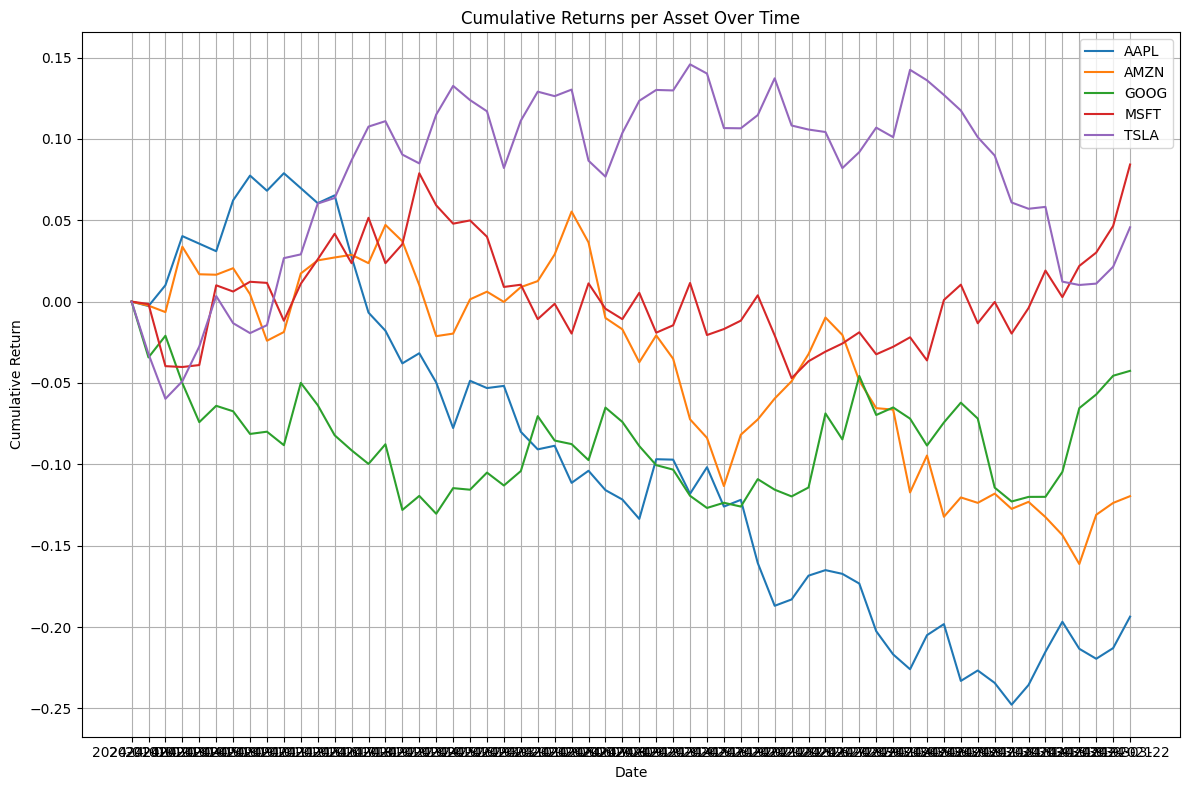

In [47]:
import matplotlib.pyplot as plt

# Make sure the DataFrame is sorted by date
df = df.sort_values('Date')

# Plot cumulative returns for all assets
plt.figure(figsize=(12, 8))
for asset in df['Asset'].unique():
    asset_data = df[df['Asset'] == asset]
    plt.plot(asset_data['Date'], asset_data['Cumulative_Return'], label=asset)

# Highlight the top asset at each time
top_dates = df['Date']
top_labels = df['Top_Asset']

plt.title("Cumulative Returns per Asset Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Task: Analyze and Compare Asset Volatility and Performance Over Time
You are provided a DataFrame with daily trading data for multiple assets. Your job is to:

Compute Daily Returns for each asset. Compute 10-day Rolling Volatility of returns per asset. Compute Cumulative Returns per asset. Find the top-performing asset each month based on cumulative return.

Create a summary DataFrame with:
Asset name, Average daily return, Standard deviation of returns, Final cumulative return, Number of high-volatility days (volatility > 2× rolling mean)

(Optional) Plot : Price and cumulative return of the top asset. Number of high-volatility days per asset (bar chart).

In [ ]:
# Daily Returns
df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()

# 10-days Rolling Volatility
df['Rolling_Volatility'] = df.groupby('Asset')['Daily_Return'].rolling(window=10).std().reset_index(0, drop=True)

# Cumulative Returns
df['Cumulative_Return'] = df.groupby('Asset')['Price'].transform(lambda x: x/x.iloc[0] - 1)

# 1. Add a 'Month' column to your DataFrame
df['Month'] = df['Date'].dt.to_period('M')  # e.g. '2024-01'

# 2. For each month, get the index of the row with the max cumulative return
top_indices = df.groupby('Month')['Cumulative_Return'].idxmax()

# 3. Use those indices to get the actual rows from the original DataFrame
monthly_top_assets = df.loc[top_indices]

# 4. Optional: Reset the index for a clean result
monthly_top_assets = monthly_top_assets.reset_index(drop=True)



Task: Detect Sharp Price Drops (Mini Crash Detection)
You're given a DataFrame df with columns:
Date, Asset, Price, Volume

Goal:
Compute daily returns per asset

Flag any day where the daily return is less than -5% as a "Crash Day"

Create a new column "Crash" with value 1 if it's a crash day, else 0

For each asset, count how many crash days it has had

Sort and show the top 3 assets with the most crashes

In [51]:
df = pd.read_csv('Simulated_Asset_Prices_with_Crashes.csv')

df['Daily_Return'] = df.groupby('Asset')['Prices'].pct_change()
df['Crash'] = (df['Daily_Return'] < -0.05).astype(int)

crashes = defaultdict(int)
for asset in df['Asset'].unique():
    somme = df[df['Asset'] == asset]['Crash'].sum()
    crashes[asset] = somme
top_assets = sorted(crashes, key=lambda x : -crashes[x])[:3]

In [52]:
df

,Date,Asset,Prices,Daily_Return,Crash
0,2024-01-01,AAPL,101.043428,NaN,0
1,2024-01-02,AAPL,100.814536,-0.002265,0
2,2024-01-03,AAPL,100.392822,-0.004183,0
3,2024-01-04,AAPL,99.972905,-0.004183,0
4,2024-01-05,AAPL,93.333581,-0.066411,1
...,...,...,...,...,...
895,2024-06-24,TSLA,59.391936,-0.057927,1
896,2024-06-25,TSLA,59.940195,0.009231,0
897,2024-06-26,TSLA,61.053805,0.018579,0
898,2024-06-27,TSLA,61.840367,0.012883,0


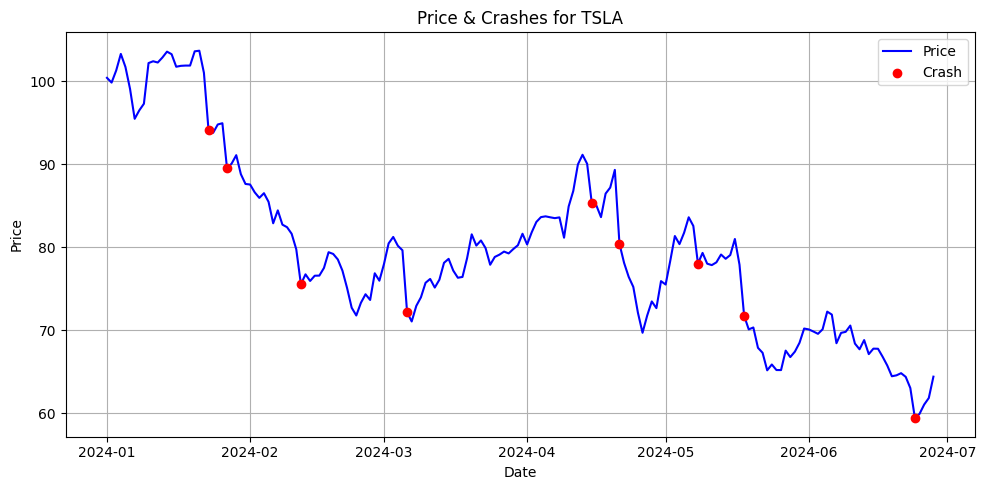

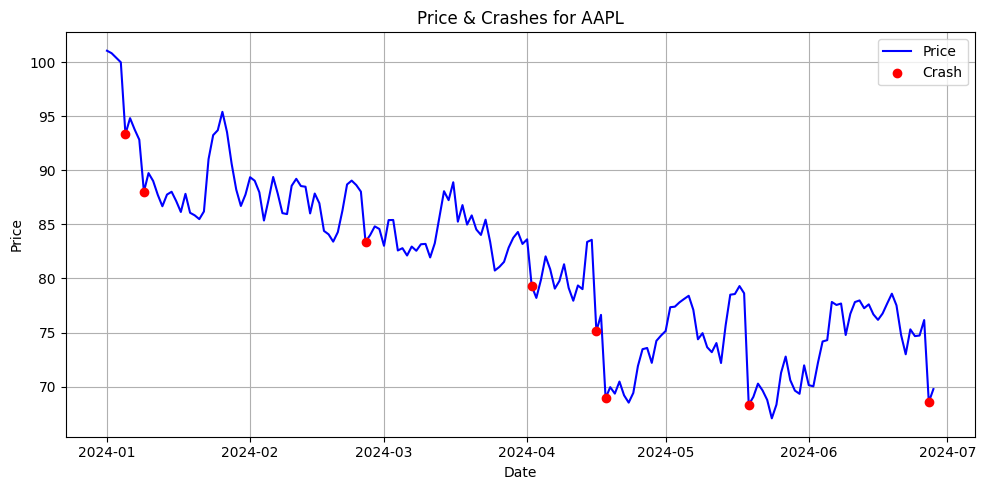

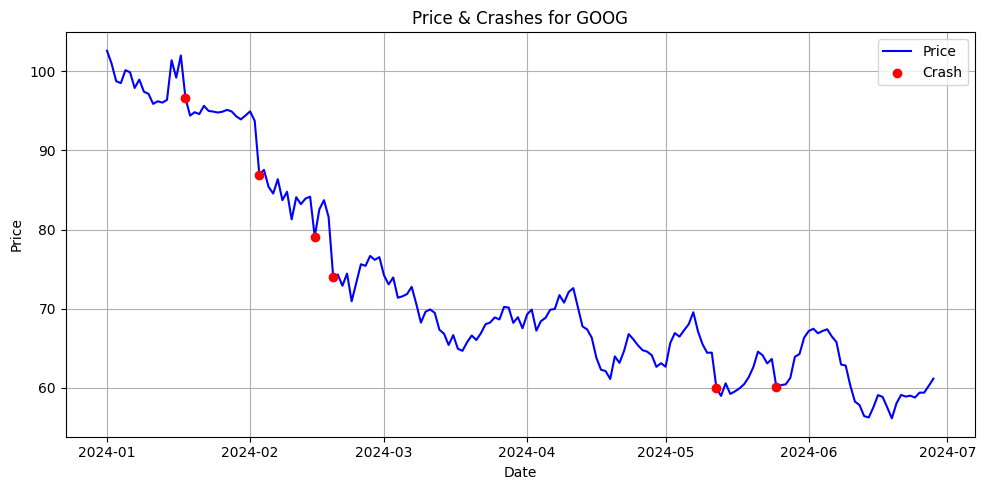

In [53]:
import matplotlib.pyplot as plt

# Make sure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Plot each top crashing asset
for asset in top_assets:
    asset_data = df[df['Asset'] == asset].copy()

    plt.figure(figsize=(10, 5))
    plt.plot(asset_data['Date'], asset_data['Prices'], label='Price', color='blue')
    
    # Highlight crash days
    crash_days = asset_data[asset_data['Crash'] == 1]
    plt.scatter(crash_days['Date'], crash_days['Prices'], color='red', label='Crash', zorder=5)

    plt.title(f"Price & Crashes for {asset}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Task: Volatility Crash Detection and Post-Crash Performance

Context: You are given historical price and volume data for several assets.

Goal: Identify crashes and analyze asset behavior after the crash.

👇 What you have to do:
Compute daily returns per asset.

Define a crash as a return < -5%.

For each crash, compute the average return over the next 3 days.

For each asset, compute:

Total number of crashes.

Average 3-day recovery return after crashes.

📈 Bonus: Try plotting the price of one of the assets around a crash date to visualize the crash + recovery.

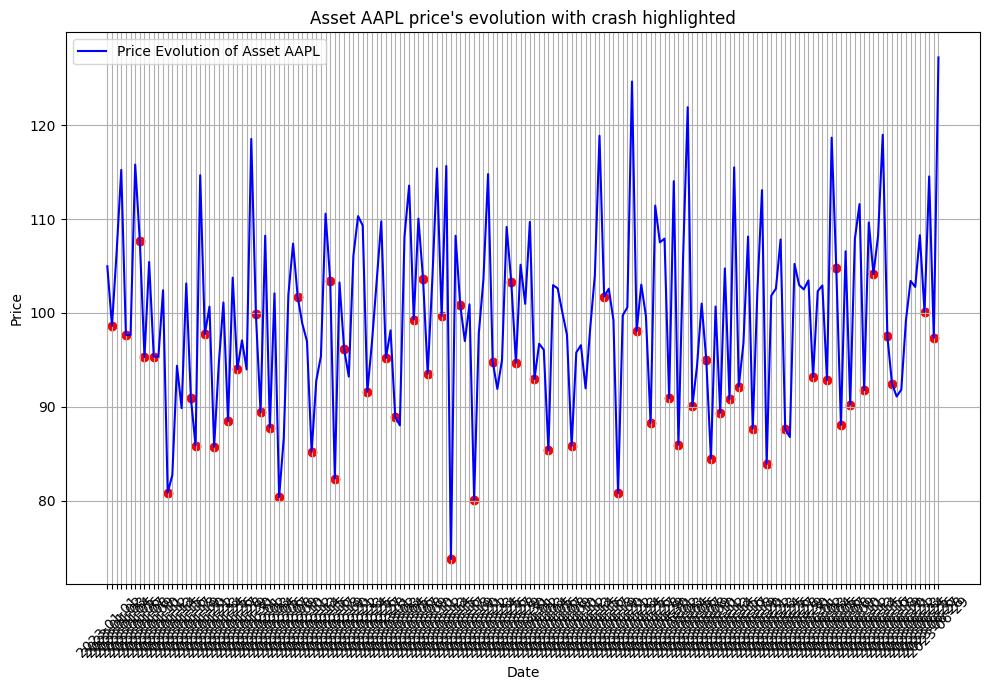

In [59]:
df = pd.read_csv('Synthetic_Asset_Price_Data.csv')

df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()

# I decide to represent a crash as 0 or 1
df['Crash'] = (df['Daily_Return'] < -0.05).astype(int)
asset_data = df[df['Crash'] == 1] # we extract the data lines where we have a crash
crash_days_indexes = asset_data.index # i need their original indexes for the 3-day av return

following_returns = []
# Average return over the next 3 days
for i in crash_days_indexes:
    if i+3 < len(df):
        average_return = df.iloc[i+1:i+4]['Daily_Return'].mean()
        following_returns.append(average_return)

# Total number of crashes for each asset
crashes = defaultdict(int)
for asset in df['Asset'].unique():
    crashes[asset] = asset_data[asset_data['Asset'] == asset]['Crash'].sum()

# Plotting of the price of one of the assets around a crash date
asset_name = 'AAPL'
asset_df = df[df['Asset'] == asset_name]
crash_points = asset_df[asset_df['Crash'] == 1]

plt.figure(figsize=(10, 7))
plt.plot(asset_df['Date'], asset_df['Price'], color="blue", label=f"Price Evolution of Asset {asset_name}")
plt.scatter(crash_points['Date'], crash_points['Price'], color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Asset {asset_name} price's evolution with crash highlighted")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()


Task: Trend Strength & Asset Momentum. Identify the top 2 momentum-driven assets in each month based on their average 10-day rolling return — and visualize their monthly price evolution.

Load the dataset and convert the Date column to datetime

Compute the daily return for each asset

Compute the 10-day rolling average return for each asset

Assign a Month column (df['Month'] = df['Date'].dt.to_period('M'))

For each month, identify the top 2 assets with the highest average 10-day rolling return in that month

Plot the price evolution of those 2 assets over that month





In [60]:
df = pd.read_csv('Extended_Synthetic_Asset_Price_Data.csv')

# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Compute the daily return for each asset
df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()

# Compute the 10-day rolling average return for each asset
df['Rolling_Average_Return'] = df.groupby('Asset')['Daily_Return'].rolling(window=10).mean().reset_index(0, drop=True)

# Assign a Month column
df['Month'] = df['Date'].dt.to_period('M')

# My version : not optimal
# top_monthly_assets = defaultdict(list)
# for month in df['Month'].unique():
# rolling_returns = df[df['Month'] == month]['Rolling_Average_Return']
# wanted_returns = sorted(rolling_returns, key=lambda x: -x)[0:2]
# for asset in df['Asset'].unique():
#     if df[df['Asset'] == asset]['Rolling_Average_Return'] in wanted_returns:
#        top_monthly_assets[month].append(asset)


# Group by Month and Asset, compute mean rolling average return
monthly_asset_returns = df.groupby(['Month', 'Asset'])['Rolling_Average_Return'].mean().reset_index()

top_monthly_assets = defaultdict(list)

# Loop through each month
for month in monthly_asset_returns['Month'].unique():
    monthly_data = monthly_asset_returns[monthly_asset_returns['Month'] == month]
    top_assets = monthly_data.sort_values('Rolling_Average_Return', ascending=False).head(2)
    top_monthly_assets[month] = top_assets['Asset'].tolist()

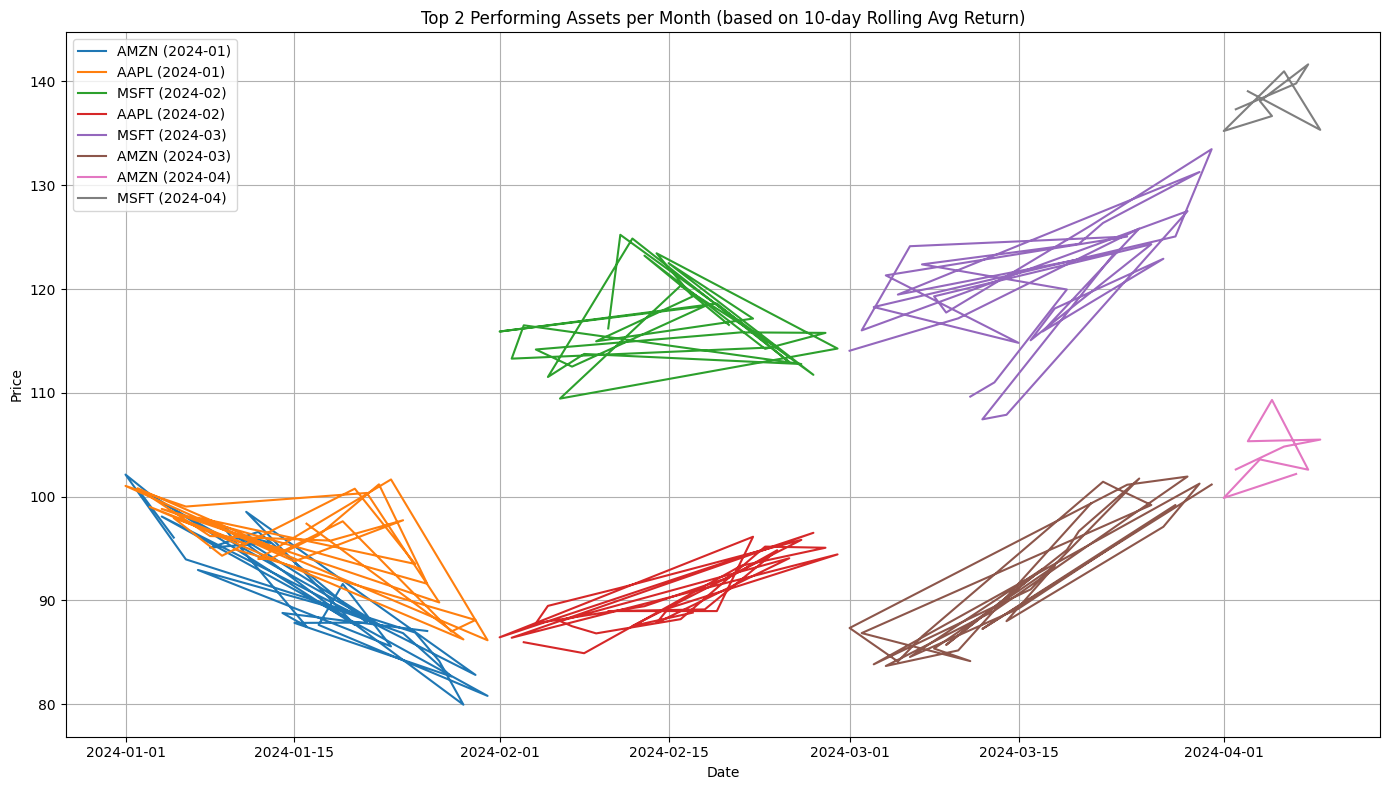

In [61]:
import matplotlib.pyplot as plt

# Plot the price evolution of top monthly assets
plt.figure(figsize=(14, 8))

# Plot each top asset for each month
for month, assets in top_monthly_assets.items():
    for asset in assets:
        asset_data = df[(df['Asset'] == asset) & (df['Month'] == month)]
        plt.plot(asset_data['Date'], asset_data['Price'], label=f"{asset} ({month})")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Top 2 Performing Assets per Month (based on 10-day Rolling Avg Return)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

You're given a function that computes the price of a European call option using the Black-Scholes formula.
You’re asked: How would you estimate the Delta of the option numerically, using finite differences ?

In [1]:
def delta_estimation(eps):
    return (function(S0 + eps, etc, ) - function(S0 - eps)) / 2*eps
# i used central bc more precise

Write a function that, given a list of daily prices, returns the maximum drawdown.
The maximum drawdown is the maximum observed loss from a peak to a trough before a new peak is reached. It’s usually expressed as a percentage.

In [2]:
def drawdown(prices):
    n = len(prices)
    peak = prices[0]
    max_drawdown = 0
    for i in range(1, n):
        drawdown = (peak - prices[i]) / peak
        max_drawdown = max(drawdown, max_drawdown)
        if prices[i] > peak:
            peak = prices[i]
    return max_drawdown

Task: Compute the Maximum Uptrend Streak
You're given a list of daily asset prices.
Your goal is to compute the longest streak of consecutive days where the price increases compared to the previous day.

In [3]:
def longest_streak(prices):
    n = len(prices)
    longest = 0
    i = 0
    while i < n:
        j = i
        current = 1
        while j + 1 < n and prices[j+1] > prices[j]:
            current += 1
            j += 1
        longest = max(longest, current)
        i = j + 1
    return longest

Rolling Max Drawdown (windowed)
For every time step t, compute the maximum drawdown over the previous window prices.
Return a list of the same length as prices, filled with None for indices < window-1.
Reminder: max drawdown is defined as min(price / peak - 1) over the window.

In [5]:
def rolling(prices, k):
    n = len(prices)
    output = [0]*(n-k+1)
    for i in range(n-k+1):
        liste = prices[i:i+k]
        drawdown = drawdown(liste)
        output[i] = drawdown
    return output

Given an unsorted list of integers, return the length of the longest consecutive elements sequence.

In [6]:
def longest_sequence(nums):
    num_set = set(nums)
    longest = 0
    for num in num_set:
        if num-1 not in num_set:
            current = 1
            while num + 1 in num_set:
                current += 1
                num += 1
            longest = max(longest, current)
    return longest

Problem: Find the First Unique Character
Given a string s, return the index of the first non-repeating character. If none exists, return -1.

In [7]:
from collections import defaultdict
from collections import Counter

def first_unique(string):
    counts = Counter(string)
    for i, char in enumerate(string):
        if counts[char] == 1:
            return i
    return -1

Task: Groupwise Statistics and Filtering
You're given a DataFrame df with the following columns:
'Date' (datetime)
'Asset' (str)
'Price' (float)
'Volume' (float)
Objective:
Compute the daily return for each asset.
Compute the average volume for each asset.
For each asset, mark a new column 'High_Volume' as 1 if the day’s volume is above the asset's average volume, else 0.
Filter and return the top 5 days (across all assets) with the highest daily returns on high volume days.

In [ ]:
df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()
# This df['Mean_Volume'] = df.groupby('Asset')['Volume'].mean() only does create sthg like :
# GOOG   312.5
# AMZ    435.7 etc etc but we want the mean to be added to the entire dataset
df['Mean_Volume'] = df.groupby('Asset')['Volume'].transform('mean')
df['High_Volume'] = (df['Volume'] > df['Mean_Volume']).astype(int)

# Top 5 days (in terms of daily returns) among high volume days
top_5 = df[df['High_Volume'] == 1].sort_values('Daily_Return', ascending=False).head(5)

Task: Detect Trend Reversals in Asset Prices
You are given a DataFrame df with the following columns: 'Date', 'Asset', 'Price'
Your job is to:
Compute daily returns.
Detect local minima and maxima (trend reversals) based on the price.
For each asset, flag the row as:
1 for a local minimum ,-1 for a local maximum ,0 otherwise.
Add a column "Reversal" with these flags.
Plot the asset's price over time, highlighting reversal points in red (maxima) and green (minima).

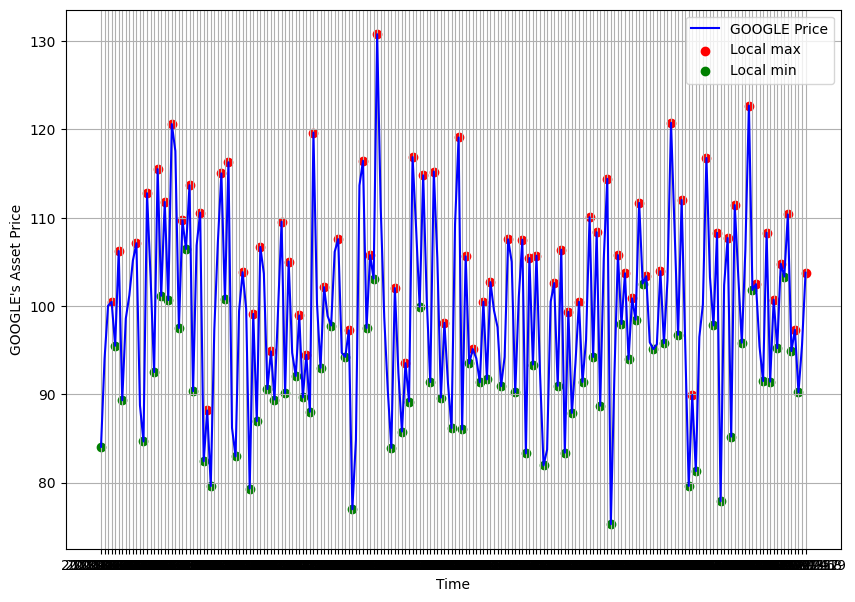

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('Synthetic_Financial_Data.csv')

df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()
flags = [0]
for i in range(1, len(df)-1):
    if df.loc[i, 'Price'] > max(df.loc[i-1, 'Price'], df.loc[i+1, 'Price']):
        flags.append(-1)
    elif df.loc[i, 'Price'] < min(df.loc[i-1, 'Price'], df.loc[i+1, 'Price']):
        flags.append(1)
    else:
        flags.append(0)
flags.append(0) # so it has the same size as df
df['Reversal'] = flags

asset = 'GOOGLE'
asset_df = df[df['Asset'] == asset]
plt.figure(figsize=(10, 7))
plt.plot(asset_df['Date'], asset_df['Price'], color="blue", label=f"{asset} Price")
plt.scatter(asset_df[asset_df['Reversal'] == -1]['Date'], asset_df[asset_df['Reversal'] == -1]['Price'], color="red", label="Local max")
plt.scatter(asset_df[asset_df['Reversal'] == 1]['Date'], asset_df[asset_df['Reversal'] == 1]['Price'], color="green", label="Local min")
plt.xlabel("Time")
plt.ylabel(f"{asset}'s Asset Price")
plt.grid(True)
plt.legend()
plt.show()


Task : Compare Volatility Between Two Assets Over Time
Objective: You have a DataFrame with Date, Asset, Price. Compute and plot the rolling 10-day standard deviation (volatility) of returns for two assets (say, "GOOGLE" and "AAPL"), and visually compare them on the same plot.

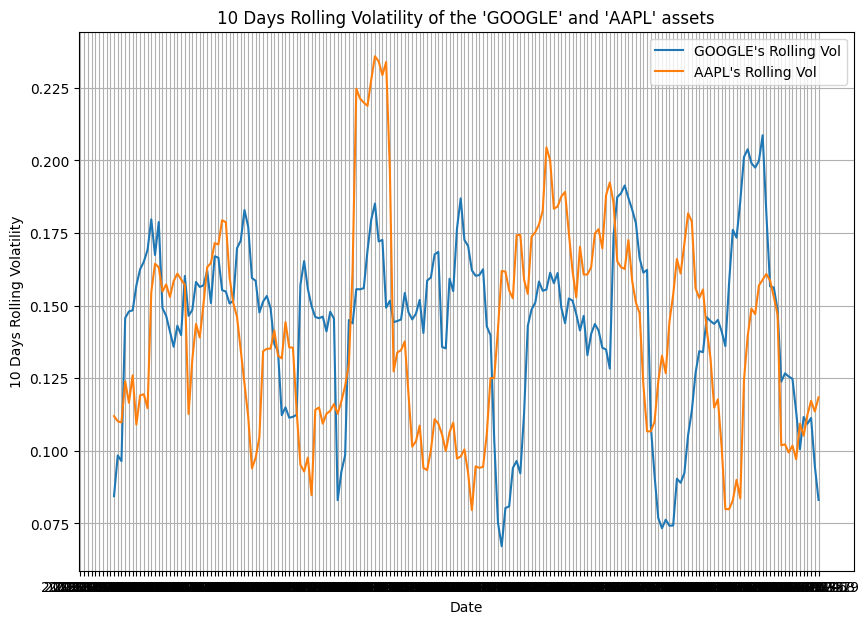

In [23]:
df['Rolling_Volatility'] = df.groupby('Asset')['Daily_Return'].rolling(window=10).std().reset_index(0, drop=True)

assets = ['GOOGLE', 'AAPL']
# We wanna plot the rolling volatilities of the two assets on the same plot
plt.figure(figsize=(10, 7))
for asset in assets:
    data = df[df['Asset'] == asset]
    plt.plot(data['Date'], data['Rolling_Volatility'], label=f"{asset}'s Rolling Vol")
plt.xlabel("Date")
plt.ylabel("10 Days Rolling Volatility")
plt.title("10 Days Rolling Volatility of the 'GOOGLE' and 'AAPL' assets")
plt.grid(True)
plt.legend()
plt.show()


"Which asset had the highest average volatility over the full time period?"
(We’ll then plot its price + volatility on the same chart.)

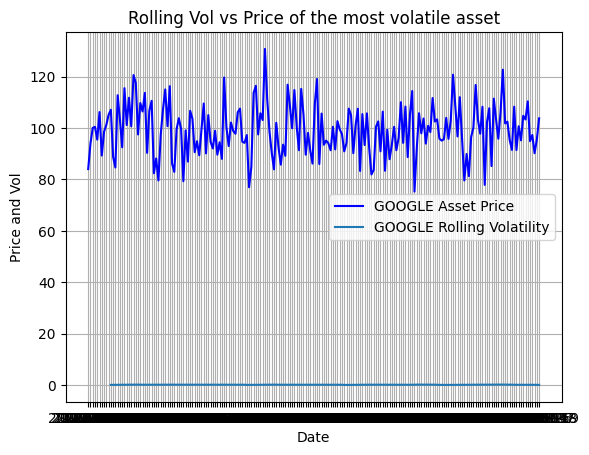

In [27]:
average_vol = defaultdict(int)

for asset in df['Asset'].unique():
    vol_sum = df[df['Asset'] == asset]['Rolling_Volatility'].sum()
    average_vol[asset] = vol_sum / len(df[df['Asset'] == asset])

max_asset = 'GOOGLE'
for key, val in average_vol.items():
    if val == max(average_vol.values()):
        max_asset = key

# Let's plot its price and volatility
asset_data = df[df['Asset'] == max_asset]
plt.plot(asset_data['Date'], asset_data['Price'], color="blue", label=f"{max_asset} Asset Price")
plt.plot(asset_data['Date'], asset_data['Rolling_Volatility'], label=f"{max_asset} Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Price and Vol")
plt.title("Rolling Vol vs Price of the most volatile asset")
plt.grid(True)
plt.legend()
plt.show()


Could be misleading to plot the price and the vol on the same y axis

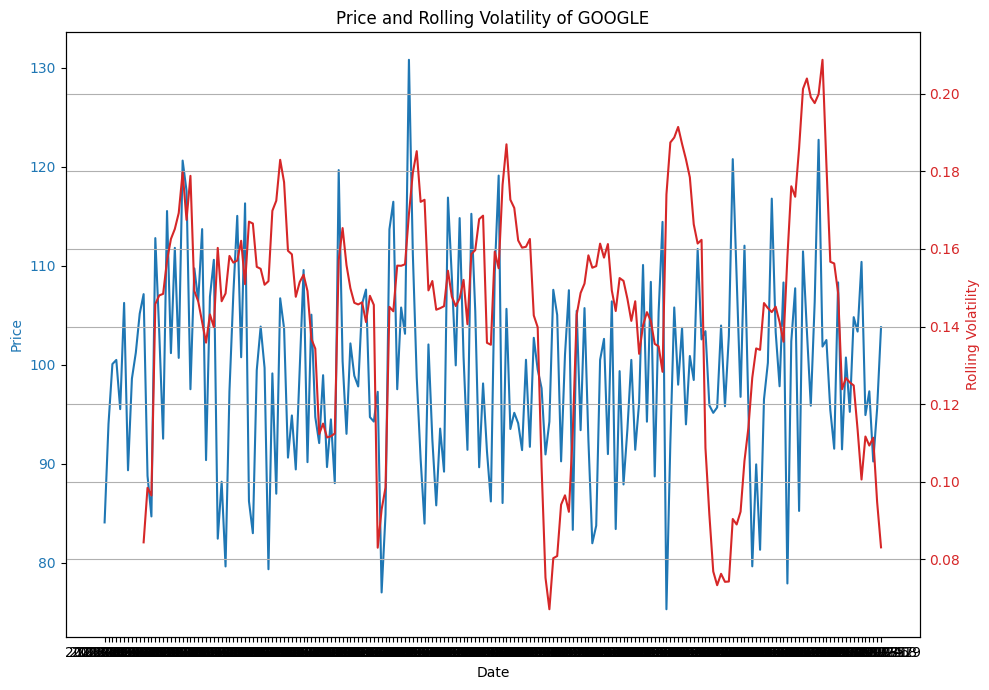

In [28]:
fig, ax1 = plt.subplots(figsize=(10, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(asset_data['Date'], asset_data['Price'], color=color, label='Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Create a second y-axis
color = 'tab:red'
ax2.set_ylabel('Rolling Volatility', color=color)
ax2.plot(asset_data['Date'], asset_data['Rolling_Volatility'], color=color, label='Volatility')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Price and Rolling Volatility of {max_asset}")
fig.tight_layout()
plt.grid(True)
plt.show()

Your goal: For each asset, identify crash days (daily return < -5%) and check if they are followed by a volatility cluster — defined as a 5-day window where rolling volatility stays above the 90th percentile of the asset’s overall volatility

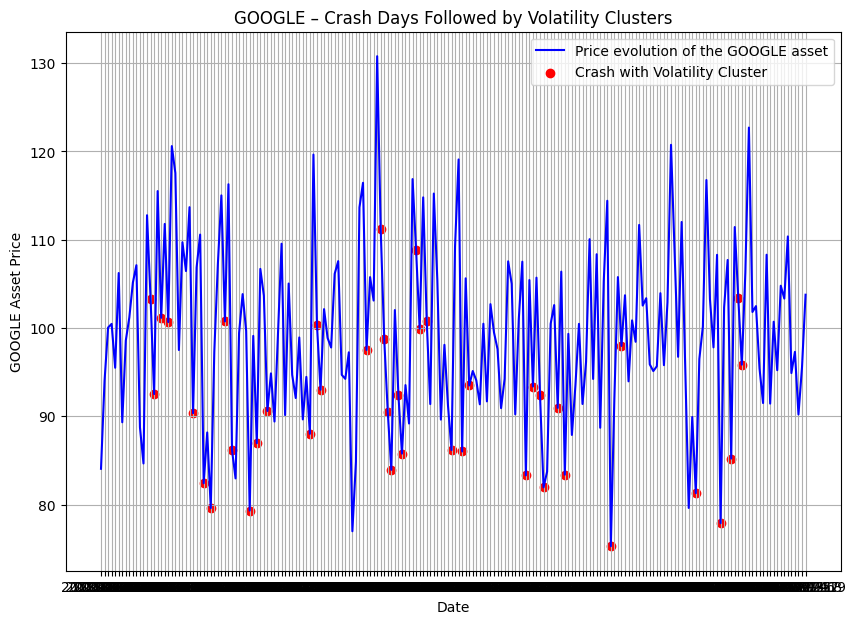

In [45]:
# We work with the same df as previously.

crash_days = df[df['Daily_Return'] < -0.05]

# Let's compute overall volatility of each asset
df['Overall_Volatility'] = df.groupby('Asset')['Daily_Return'].transform('std')

threshold = df.groupby('Asset')['Overall_Volatility'].transform(lambda x: x.quantile(0.9))

crash_days_followed_by_cluster = []
for i in crash_days.index:
    if i+5 < len(df):
        vol_series = df.loc[i+1:i+5, 'Rolling_Volatility']
        threshold_i = threshold[i]
        if (vol_series > threshold_i).all():
            crash_days_followed_by_cluster.append(i)

df['Volatility_Cluster_After_Crash'] = 0
df.loc[crash_days_followed_by_cluster, ['Volatility_Cluster_After_Crash']] = 1

# Let's now represent the crush days followed by cluster for the asset 'GOOGLE'1643715385504.pdf

chosen_asset = 'GOOGLE'
data_g = df[df['Asset'] == chosen_asset]
# Filter crash points among the Google asset
crash_data = data_g[data_g['Volatility_Cluster_After_Crash'] == 1]

plt.figure(figsize=(10, 7))
plt.plot(data_g['Date'], data_g['Price'], color="blue", label=f"Price evolution of the {chosen_asset} asset")
plt.scatter(crash_data['Date'], crash_data['Price'], color="red", label="Crash with Volatility Cluster")
plt.xlabel("Date")
plt.ylabel(f"{chosen_asset} Asset Price")
plt.title(f"{chosen_asset} – Crash Days Followed by Volatility Clusters")
plt.grid(True)
plt.legend()
plt.show()

In [47]:
df = pd.read_csv('Synthetic_Financial_Time_Series_Data.csv')
df

,Date,Asset,Price,Volume
0,2023-01-02,GOOGLE,1200.000000,1176615
1,2023-01-03,GOOGLE,1212.586692,1187628
2,2023-01-04,GOOGLE,1209.842945,3735988
3,2023-01-05,GOOGLE,1226.229881,3470784
4,2023-01-06,GOOGLE,1264.788509,4280143
...,...,...,...,...
745,2023-12-11,MSFT,385.417987,2024939
746,2023-12-12,MSFT,397.018365,4342861
747,2023-12-13,MSFT,414.530612,3971981
748,2023-12-14,MSFT,403.181887,4850241


Task: Identify High Volatility Periods
Goal: For each asset, detect periods where the 10-day rolling standard deviation of returns exceeds twice the asset’s overall volatility.

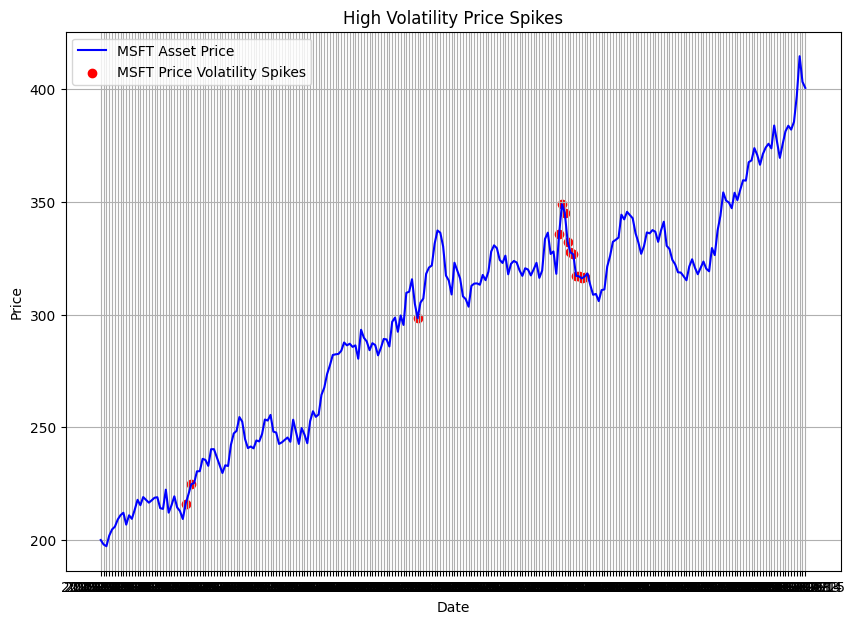

In [69]:
df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()
df['Overall_Volatility'] = df.groupby('Asset')['Daily_Return'].transform('std')
df['Rolling_Standard_Deviation'] = df.groupby('Asset')['Daily_Return'].rolling(window=10).std().reset_index(0, drop=True)

df['High_Vol'] = (df['Rolling_Standard_Deviation'] > 1.5*df['Overall_Volatility']).astype(int)
high_vol_days = df[df['High_Vol'] == 1]['Date']


# Plotting of these high vol zones on the MSFT asset price variation
asset = 'MSFT'
asset_df = df[df['Asset'] == asset]
# We focus on the high vol days
vol_data = asset_df[asset_df['High_Vol'] == 1]

plt.figure(figsize=(10, 7))
plt.plot(asset_df['Date'], asset_df['Price'], color="blue", label=f"{asset} Asset Price")
plt.scatter(vol_data['Date'], vol_data['Price'], color="red", label=f"{asset} Price Volatility Spikes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("High Volatility Price Spikes")
plt.grid(True)
plt.legend()
plt.show()

Detect Volatility Regimes
You’re analyzing time series data of asset prices. You want to:
Compute daily returns.
Calculate a 20-day rolling standard deviation of returns.
Classify each day into a volatility regime:
Low if rolling volatility < 33rd percentile (of each asset)
Medium if between 33rd and 66th percentile.
High if above 66th percentile.
Plot the volatility regimes for one asset, with color-coded background on the plot.

In [73]:
df['Rolling_Volatility'] = df.groupby('Asset')['Daily_Return'].rolling(window=20).std().reset_index(0, drop=True)

low_threshold = df.groupby('Asset')['Rolling_Volatility'].transform(lambda x: x.quantile(0.33))
high_threshold = df.groupby('Asset')['Rolling_Volatility'].transform(lambda x: x.quantile(0.66))

df['Low_Threshold'] = low_threshold
df['High_Threshold'] = high_threshold

def label_vol(row):
    if row['Rolling_Volatility'] < row['Low_Threshold']:
        return 'Low'
    elif row['Rolling_Volatility'] > row['High_Threshold']:
        return 'High'
    else:
        return 'Medium'

df['Volatility_Regime'] = df.apply(label_vol, axis=1)

Task: Intraday Volatility Spike Detection
You're working with intraday prices (let's pretend the dataset is in hourly granularity). For each asset, you want to:
Compute rolling standard deviation of hourly returns (e.g., over 5-hour windows).
Flag a spike when:
Current volatility is > 1.5× the asset's average volatility.
Count how many spikes occur per asset.

Plot the volatility spikes over the intraday price of a chosen asset.



<Figure size 1000x700 with 0 Axes>

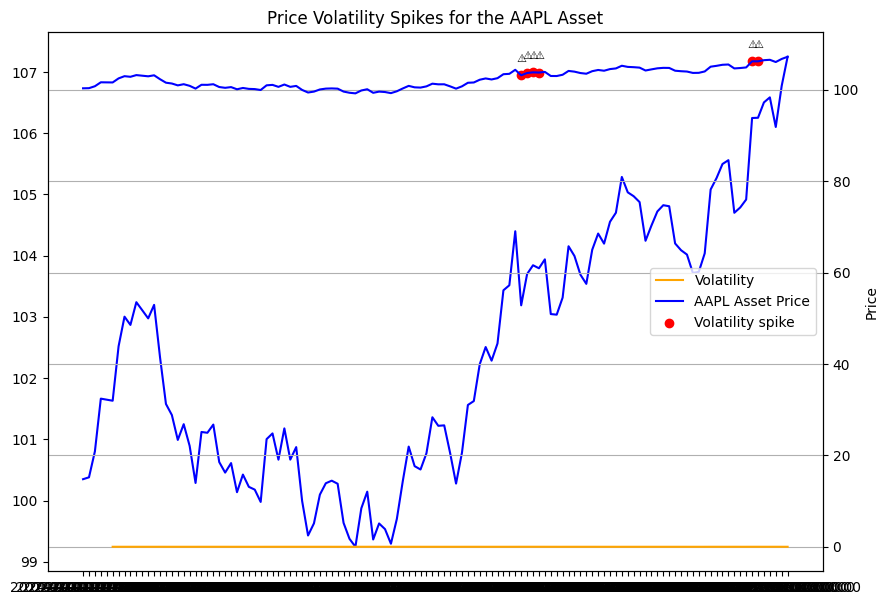

In [90]:

df = pd.read_csv("Intraday_Synthetic_Financial_Data.csv")

df['Daily_Return'] = df.groupby('Asset')['Price'].pct_change()
df['Rolling_Standard_Deviation'] = df.groupby('Asset')['Daily_Return'].rolling(window=5).std().reset_index(0, drop=True)
df['Volatility'] = df.groupby('Asset')['Daily_Return'].transform('std').reset_index(0, drop=True)
df['Flag'] = (df['Rolling_Standard_Deviation'] > 1.5*df['Volatility']).astype(int)

# Compute spike frequency over time (chat GPT)
df['DateOnly'] = pd.to_datetime(df['Date']).dt.date
spike_freq = df[df['Flag'] == 1].groupby(['Asset', 'DateOnly']).size()

# Count how many spikes occur per asset
spikes = defaultdict(int)
for asset in df['Asset'].unique():
    asset_data = df[df['Asset'] == asset]
    spikes[asset] = len(asset_data[asset_data['Flag'] == 1])

# Plotting of the 'AAPL' asset
chosen_asset = 'AAPL'
asset_data = df[df['Asset'] == chosen_asset]
spikes_data = asset_data[asset_data['Flag'] == 1]

plt.figure(figsize=(10, 7))

# Add a second y-axis to show rolling volatility alongside price (chat GPT)
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(asset_data['Date'], asset_data['Price'], color='blue', label='Price')
ax2 = ax1.twinx()
ax2.plot(asset_data['Date'], asset_data['Rolling_Standard_Deviation'], color='orange', label='Volatility')

plt.plot(asset_data['Date'], asset_data['Price'], color="blue", label=f"{chosen_asset} Asset Price")
plt.scatter(spikes_data['Date'], spikes_data['Price'], color="red", label=f"Volatility spike")
for idx, row in spikes_data.iterrows():
    plt.annotate("⚠", (row['Date'], row['Price']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Price Volatility Spikes for the {chosen_asset} Asset")
plt.grid(True)
plt.legend()
plt.show()


Classify each day for each asset into a performance regime based on their daily returns:
'Loss' if daily return < -0.5%
'Flat' if daily return between -0.5% and +0.5%
'Gain' if daily return > 0.5%
Then:
Count how many times each asset falls into each regime.
Plot a bar chart showing the distribution of regimes per asset.

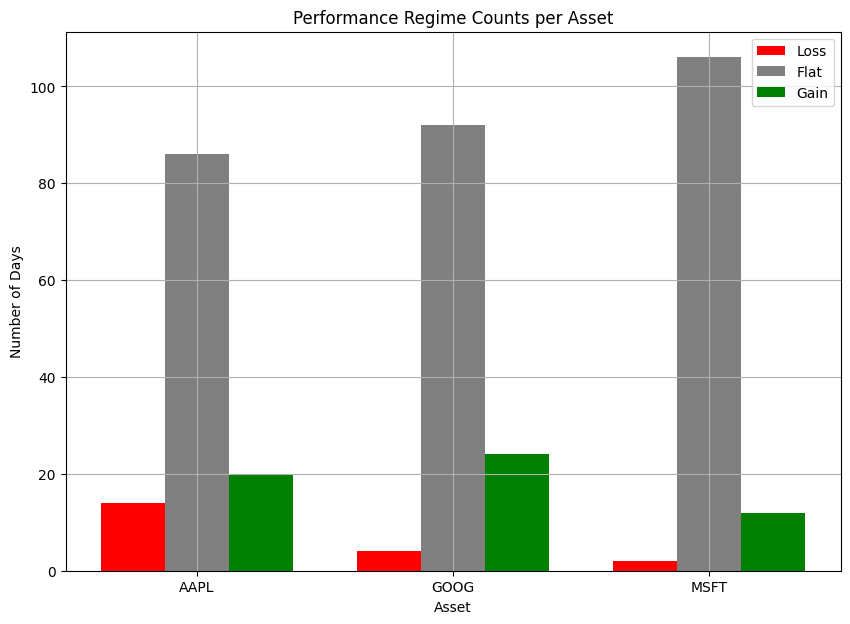

In [97]:
from collections import Counter
from collections import defaultdict

def classification(row):
    if row['Daily_Return'] < -0.005:
        return 'Loss'
    elif row['Daily_Return'] > 0.005:
        return 'Gain'
    else:
        return 'Flat'

df['Performance'] = df.apply(classification, axis=1)

regime_counts = defaultdict(Counter)
for asset in df['Asset'].unique():
    performance = df[df['Asset'] == asset]['Performance']
    regime_counts[asset] = Counter(performance)

# Prepare for plotting
labels = ['Loss', 'Flat', 'Gain']
assets = list(regime_counts.keys())

# Set bar positions
x = range(len(assets))
bar_width = 0.25

# Collect height of each bar for each regime
loss_counts = [regime_counts[asset]['Loss'] for asset in assets]
flat_counts = [regime_counts[asset]['Flat'] for asset in assets]
gain_counts = [regime_counts[asset]['Gain'] for asset in assets]

plt.figure(figsize=(10, 7))
plt.bar([i - bar_width for i in x], loss_counts, width=bar_width, label='Loss', color='red')
plt.bar(x, flat_counts, width=bar_width, label='Flat', color='gray')
plt.bar([i + bar_width for i in x], gain_counts, width=bar_width, label='Gain', color='green')

plt.xticks(x, assets)
plt.xlabel("Asset")
plt.ylabel("Number of Days")
plt.title("Performance Regime Counts per Asset")
plt.legend()
plt.grid(True)
plt.show()

Short-term MA: e.g., 5-day average — reacts quickly to price changes.
Long-term MA: e.g., 20-day average — smoother, used to detect overall trend.

Golden Cross: Short MA crosses above long MA → bullish signal.
Death Cross: Short MA crosses below long MA → bearish signal.

With diff, we have this :

+1 → Bearish to Bullish → Golden Cross 🌟

-1 → Bullish to Bearish → Death Cross 💀

NaN or 0 → no change

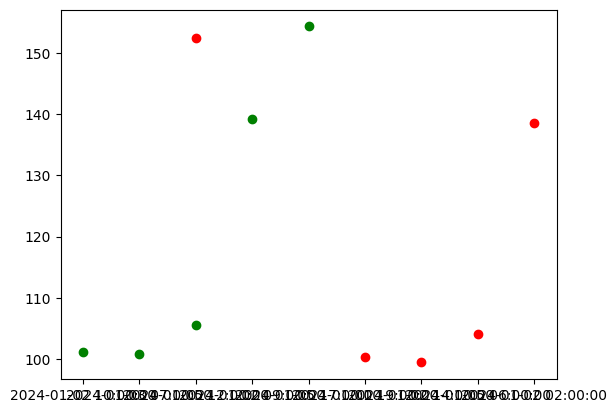

In [103]:
df['Short_MA'] = df.groupby('Asset')['Price'].rolling(window=5).mean().reset_index(0, drop=True)
df['Long_MA'] = df.groupby('Asset')['Price'].rolling(window=20).mean().reset_index(0, drop=True)

# I decide to represent a Bullish signal as a 0 and a Bearish signal as 1.
df['Cross'] = (df['Short_MA'] < df['Long_MA']).astype(int)
# But if I do that, it will only give me a binary signal. I wont identify the moment where they cross.
# To detect changes, I have to do that:
df['Signal'] = df.groupby('Asset')['Cross'].diff()

bullish = df[df['Signal'] == -1]
bearish = df[df['Signal'] == 1]

plt.scatter(bullish['Date'], bullish['Price'], color='green', label='Golden Cross')
plt.scatter(bearish['Date'], bearish['Price'], color='red', label='Death Cross')

In [104]:
df

,Date,Asset,Price,Volume,Daily_Return,Rolling_Standard_Deviation,Volatility,Flag,DateOnly,Performance,Short_MA,Long_MA,Cross,Signal
0,2024-01-01 00:00:00,AAPL,100.348357,1155.803954,NaN,NaN,0.004529,0,2024-01-01,Flat,NaN,NaN,0,NaN
1,2024-01-01 01:00:00,AAPL,100.379225,1459.821674,0.000308,NaN,0.004529,0,2024-01-01,Flat,NaN,NaN,0,0.0
2,2024-01-01 02:00:00,AAPL,100.803069,967.371955,0.004222,NaN,0.004529,0,2024-01-01,Flat,NaN,NaN,0,0.0
3,2024-01-01 03:00:00,AAPL,101.664584,1120.513517,0.008547,NaN,0.004529,0,2024-01-01,Gain,NaN,NaN,0,0.0
4,2024-01-01 04:00:00,AAPL,101.647507,1207.043198,-0.000168,NaN,0.004529,0,2024-01-01,Flat,100.968549,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2024-01-05 19:00:00,MSFT,154.103470,1330.990565,-0.002274,0.003128,0.003193,0,2024-01-05,Flat,154.156408,153.435435,0,0.0
356,2024-01-05 20:00:00,MSFT,154.244213,1034.268295,0.000913,0.002144,0.003193,0,2024-01-05,Flat,154.272175,153.488055,0,0.0
357,2024-01-05 21:00:00,MSFT,154.249884,1045.090528,0.000037,0.001327,0.003193,0,2024-01-05,Flat,154.273309,153.541493,0,0.0
358,2024-01-05 22:00:00,MSFT,154.561243,890.916336,0.002019,0.001612,0.003193,0,2024-01-05,Flat,154.322709,153.592677,0,0.0


Compute a 10-day momentum per asset and create a Momentum column in your DataFrame.
Once you're done, we'll:
Use it to classify the market as "Accelerating", "Slowing", or "Neutral"
Plot it for one asset

Momentum measures how much the price has changed over a given number of days.
If you choose a window of 10 days, then:

Momentum at time t = Price at day t − Price at day t−10

In [112]:
df['Momentum'] = df.groupby('Asset')['Price'].transform(lambda x: x - x.shift(10))
# No need to reset index here bc in pandas, transform returns a series of the same length as the original one (contrary to rolling)
# If we wanted 10 days in the future, shift(-10)

# Classification Market
def classification(row):
    if row['Momentum'] > 0:
        return "Accelerating"
    elif row['Momentum'] < 0:
        return "Slowing"
    else:
        return "Neutral"

df['Market_Dynamics'] = df.apply(classification, axis=1)

In [120]:
# To detect missing data 

# Option 1: Boolean DataFrame showing where values are missing (not a huge fan of this, not visually confortabe)
missing_mask = df.isna()

# Option 2: Get positions (row, col) of missing values
missing_positions = [(i, col) for i, row in df.iterrows() for col in df.columns if pd.isna(row[col])]


In [121]:
# Total missing values per column
df.isna().sum()

Date                           0
Asset                          0
Price                          0
Volume                         0
Daily_Return                   3
Rolling_Standard_Deviation    15
Volatility                     0
Flag                           0
DateOnly                       0
Performance                    0
Short_MA                      12
Long_MA                       57
Cross                          0
Signal                         3
Momentum                      30
Market_Dynamics                0
dtype: int64

In [129]:
# Total missing values in the whole DataFrame (isna: is not available)
df.isna().sum().sum()

np.int64(120)

In [124]:
# Rows with missing data (NaN : not a number)
df.isna().any(axis=1)

0       True
1       True
2       True
3       True
4       True
       ...  
355    False
356    False
357    False
358    False
359    False
Length: 360, dtype: bool

See which rows contains missing value : df[df.isna().any(axis=1)]
Quick overview : df.info() 

A. Drop Missing Values (when the amount of missing data is small or irrelevant)

df.dropna()                    # Drops any row with a missing value

df.dropna(subset=['Price'])   # Drops only if 'Price' is missing

df.dropna(axis=1)              # Drops columns instead of row

B. Fill with a Default or Computed Value (when the data is important)

df.fillna(0)                             # Replace NaNs with 0

df['Price'].fillna(df['Price'].mean())  # Replace with mean (per column)

df['Price'].fillna(method='ffill')      # Forward fill: use previous value

df['Price'].fillna(method='bfill')      # Backward fill: use next value

df['Price'] = df.groupby('Asset')['Price'].transform(lambda x: x.fillna(x.mean())) # Replace with the mean price for each asset


C. Outliers

An outlier is a data point that significantly differs from others in the dataset. Techniques to detect them:

1.Standard Deviation Method (Z-Score) (detect outlier points as far from the mean) (assumes a normal distribution)

mean = df['Daily_Return'].mean()

std = df['Daily_Return'].std()

df['Z_Score'] = (df['Daily_Return'] - mean) / std

df['Outlier'] = (df['Z_Score'].abs() > 3).astype(int)   # Flag as outlier if Z-score > 3




2.Interquartile Range Method

Q1 = df['Daily_Return'].quantile(0.25)

Q3 = df['Daily_Return'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR

upper_bound = Q3 + 1.5 * IQR

df['Outlier'] = ((df['Daily_Return'] < lower_bound) | (df['Daily_Return'] > upper_bound)).astype(int)

3.Rolling Window Anomaly Detection

df['Rolling_Mean'] = df['Daily_Return'].rolling(window=5).mean()

df['Rolling_Std'] = df['Daily_Return'].rolling(window=5).std()

df['Rolling_Outlier'] = ((df['Daily_Return'] - df['Rolling_Mean']).abs() > 2 * df['Rolling_Std']).astype(int)

<Axes: xlabel='Daily_Return'>

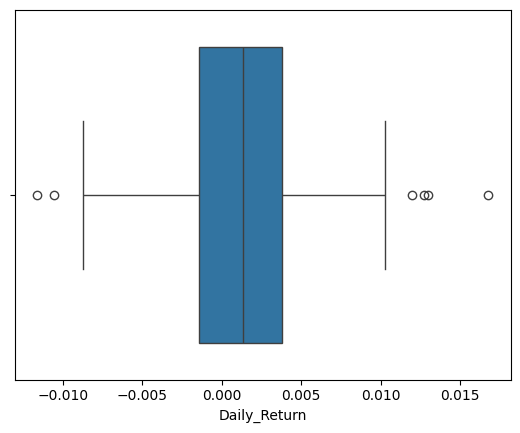

In [130]:
# Outliers visualization

import seaborn as sns
sns.boxplot(x=df['Daily_Return'])

Standardization (Z-Score)

df['Standardized_Return'] = (df['Daily_Return'] - df['Daily_Return'].mean()) / df['Daily_Return'].std()

With sklearn :

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df['Standardized_Price'] = scaler.fit_transform(df[['Price']])

Normalization (Min-Max scaling)

df['Normalized_Price'] = (df['Price'] - df['Price'].min()) / (df['Price'].max() - df['Price'].min())

With sklearn :

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df['Normalized_Volume'] = scaler.fit_transform(df[['Volume']])

In [139]:
import numpy as np

def simulation_option_call_price(S0, K, r, sigma, T, N, M): # Today's price
    # N is the number of simulations
    # M is the number of subdivisions of [0, T]
    # first simulation of the BM B
    times = np.linspace(0, T, M+1)
    dt = T/M
    dB = np.random.normal(0, np.sqrt(dt), (N, M))
    B = np.zeros((N, M+1))
    B[:, 1:] = np.cumsum(dB, axis=1)
    S = S0 * np.exp((r - 0.5*sigma**2)*times + sigma*B)
    S_T = S[:, -1]
    return np.exp(-r*T)*np.mean(np.maximum(S_T - K, 0))


In [140]:
def barrier_price(S0, K, r, sigma, T, N, M): # Today's price
    # N is the number of simulations
    # M is the number of subdivisions of [0, T]
    # first simulation of the BM B
    times = np.linspace(0, T, M+1)
    dt = T/M
    dB = np.random.normal(0, np.sqrt(dt), (N, M))
    B = np.zeros((N, M+1))
    B[:, 1:] = np.cumsum(dB, axis=1)
    S = S0 * np.exp((r - 0.5*sigma**2)*times + sigma*B)
    S_T = S[:, -1]
    first_constraint = (S_T > K)
    second_constraint = np.max(S, axis=1) > 120
    payoff = (first_constraint & second_constraint).astype(int)
    return np.exp(-r*T)*np.mean(payoff)